# IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

The v9 code (OR def) is a final, cleaned and commented version.
This version, wrt to v8, implements an hourly ET0 calculated with hourly FAO-56 Penman-Monteith and a SWB model that is properly corrected for hourly calculation of the evapotranspiration.
Kc curves are also externally defined in a module of their own.

# Dependencies

In [1]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_pso import *
from modules.funcs_plot import *
from modules.funcs_analysis import *
from modules.IRRI_WCM_model import *
from modules.Kc_curve import Kc_curve
from modules.EPOT_Hargreaves_pyeto import *

from scipy.signal import savgol_filter

# Data pre-processing

Input data formatting convention:
- ausiliary variables for extraction of data (directory name, file name, etc...)
- extraction into pd dataframe
- cleaning, resampling: drop unnecessary columns, set index to daily DateIndex

In [2]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
      #+'Use of satellite-derived SM is provided for comparison, not calibration.\n'
     )
verbose = True if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

params = []; norma = ''

print('\n#-------------SWB model parameters-------------')
irri = False
year = int(input('Do you want to calibrate on year 2017 or 2020? [2017/2020]'))
freq = 'h' # input('Daily or hourly frequency? [d/h]')

print('\n#-------------WCM model parameters-------------')
units = 'lin' # input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')
opt_veg = 'NDVI'

print('\n#------------Optimization parameters-----------')
opt_calib = '1' # input('Cost function (KGE) on sigma0 (1) or sigma0 and soil moisture (2)? [1/2]')
opt_cost = 'KGE'

PAR_str_add = '_' + str(year) + input('Any addition to parameters\' names? [Type string to add]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
verbose_calib = True if input('Verbose during calibration? [y/n]')=='y' else False
automate = True if input('Run and save everything automatically? [y/n]')=='y' else False

# check if params are already present
opt_params = input('Params already present: overwrite [y] or append [n]? [y/n]') if len(params)>0 else ''
if opt_params=='y': params = []

Starting...
#-------------------------------------------------------------



Verbose data extraction? (Describe datasets/files) [y/n] 



#-------------SWB model parameters-------------


Do you want to calibrate on year 2017 or 2020? [2017/2020] 2017



#-------------WCM model parameters-------------

#------------Optimization parameters-----------


Any addition to parameters' names? [Type string to add] 
Number of runs? (10 is min to study distribution of parameters.)  200
Number of particles:  20
Number of optimization steps:  200
Global or Local PSO optimizer? [[global]/local]  
Verbose during calibration? [y/n] 
Run and save everything automatically? [y/n] y


## IRRmodel

Frequency: daily

Inputs:
- rain (sum, end of day)
- et0 (daily)

Comparisons:
- irrigation (sum, end of day)
- soil moisture (mean, end of day)

In [3]:
#----------------------------------------------------------------------------
# Budrio field data from platinum_df tables

# Freq: H
# Data extracted:
# - SWC (as input SWB/comparison)
# - rain (as input SWB)
# - irrigation (as input SWB)
# - temperature (as input SWB, ET0 estimate)

platinum_df = pd.ExcelFile('..\Inputs\Platinum_Budrio.xlsx', engine='openpyxl')
if year==2017: sheet='2017_1h'
if year==2020: sheet='2020_1h'
platinum_df = platinum_df.parse(sheet)
# platinum_df = pd.concat([platinum_df.parse('2017_1h'), platinum_df.parse('2020_1h')])

# Column 'Date' contains date+hour = hourly information
# Column 'Data' contains only date = daily information
platinum_df['Ora_1'] = pd.to_datetime(platinum_df['Ora'].astype('str')).apply(lambda x: x.time())
platinum_df['Data_1'] = pd.to_datetime(platinum_df['Data'].astype('str')).apply(lambda x: x.date())
platinum_df['Datetime'] = platinum_df.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum_df = platinum_df.drop(['ID', 'Data', 'Ora', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
platinum_df = platinum_df.set_index('Datetime')
platinum_resampled = platinum_df.resample('D', origin='end_day')
if verbose: platinum_df.info()

In [4]:
#----------------------------------------------------------------------------
# Budrio field data from meteo tables

# Freq: H
# Data extracted:
# none
# Needed for eto from FAO PM 

meteo_df = pd.ExcelFile('..\Inputs\Budrio_Meteo.xlsx', engine='openpyxl')
meteo_df = meteo_df.parse(str(year))
# meteo_df = pd.concat([meteo_df.parse('2017'), meteo_df.parse('2020')]).set_index('ID')

# Column 'Date' contains date+hour = hourly information
meteo_df['Datetime'] = meteo_df.apply(lambda r : dtt.datetime.combine(r['Data'],r['Ora']),1)
meteo_df = meteo_df.set_index('Datetime')
meteo_df = meteo_df.drop(['Data', 'Ora'],axis=1)

if verbose: meteo_df.info()
# meteo_df.head()

In [5]:
# Budrio database
# Freq: H
# Merging of Platinum+Meteo

meteo_h = pd.merge(right=platinum_df, left=meteo_df, on='Datetime')
if verbose: meteo_h.info()

In [6]:
lat_deg = 44.570842547510622 # latitude of Budrio (deg)
temp_min = platinum_resampled.min()['Temperatura[°C]'].values
temp_max = platinum_resampled.max()['Temperatura[°C]'].values
temp_mean = platinum_resampled.mean()['Temperatura[°C]'].values
dates = platinum_resampled.asfreq().index
eto = timeseries( dates,
                 [ hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates)) ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'EPOT'}).set_index('Date')
if verbose: eto_df.info()

In [7]:
# Computation of hourly eto by hourly FAO Penman-Monteith equation
# FAO-56 pag. 74

t = [x for x in meteo_h.index if x.year==year]

# Inputs
# ------
RH = meteo_h.loc[t]['Umidità aria Netsens [%] '].values if year==2017 else meteo_h.loc[t]['Umidità aria [%] '].values # mean hourly relative humidity [%]
T = meteo_h.loc[t]['Temperatura[°C]'].values # mean hourly air temperature [°C]
sol_rad = meteo_h.loc[t]['Radiazione solare [W/m2]  '].values # measured solar radiation [J m^-2 s^-1]
sol_rad_hour = sol_rad*3600*1e-6 # [MJ m^-2 h^-1]
T_dew = meteo_h.loc[t]['Punto di rugiada [C°] '].values # dew point [°C]
atmos_pres = meteo_h.loc[t]['Pressione atmosferica [hPa]  '].values/10 # atmospheric pressure [kPa]
wind_s = meteo_h.loc[t]['Velocità del vento [m/s]'].values
epot_hourly = [0.]*len(t)

# Params
# ------
for i in range(len(t)):
    
    lat_deg = 44.570842547510622 # latitude of Budrio (deg)
    lat_rad = np.deg2rad(lat_deg)
    long_deg = 11.53267200001359 # longitude of Budrio (deg)
    long_rad = np.deg2rad(long_deg)
    altitude = 11. # elevation [m]
    doy = t[i].dayofyear
    hour = t[i].hour
    mid_hour = hour+0.5
    
    # Extraterrestrial radiation (et_rad)
    Gsc = 0.0820 # MJ m^-2 min^-1
    dr = inv_rel_dist_earth_sun(doy) # inverse relative distance Earth-Sun
    d = sol_dec(doy) # solar declination [rad]
    phi = lat_rad # latitude [rad]
    lz = 360-15 # longitude of centre of local time zone (CET) (deg W of Greenwhich)
    lm = 360-long_deg # longitude of site (deg W of Greenwhich)
    b = 2*np.pi*(doy-81)/364
    Sc = 0.1645*np.sin(2*b)-0.1255*np.cos(b)-0.025*np.sin(b) # seasonal correction for solar time
    w = np.pi/12*((mid_hour+0.006667*(lz-lm)+Sc)-12) # solar time angle at midpoint of the period
    w1 = w-np.pi/24 # solar time angle at beginning [rad]
    w2 = w+np.pi/24 # solar time angle at end [rad]

    
    et_rad = 12*60/np.pi*Gsc*dr*((w2-w1)*np.sin(phi)*np.sin(d)+np.cos(phi)*np.cos(d)*(np.sin(w2)-np.sin(w1)))
    
    ws = np.arccos(-np.tan(lat_rad)*np.tan(d))
    N = 24/np.pi*ws # daylight hours
    Rs = sol_rad_hour[i] # measured solar radiation [MJ m^-2 h^-1]
    Rso = cs_rad(altitude, et_rad) # clear sky radiation [MJ m^-2 h^-1]
                                 
    avp = avp_from_tdew(T_dew[i]) # actual vapour pressure
    ni_rad = net_in_sol_rad(Rs) # net incoming solar radiation # use this formula, albedo is default value
                                 
    boltz_h = 2.043*1e-10 # Boltzmann constant [MJ m^-2 h^-1]
    e_thr = svp_from_t(T[i]) # saturation vapour pressure
    e_a = e_thr*RH[i]/100# average hourly actual vapour pressure
    Rs_ratio = Rs/Rso if Rs/Rso<1 else 1
    no_rad = boltz_h*T[i]**4*(0.34-0.14*np.sqrt(e_a))*(1.35*Rs_ratio-0.35) # net outgoing radiation corrected for hourly period
    R_n = ni_rad - no_rad # net radiation at grass surface
    
    u2 = wind_s[i]
    G = 0.1*R_n if hour in range(6,18,1) else 0.5*R_n # soil heat flux density, ref. eq. 45, 46 FAO56
    Delta = delta_svp(T[i]) #saturation slope
    gamma = psy_const(atmos_pres[i])# psychrometric constant
    
    epot_hourly[i] = (0.408*Delta*(R_n-G)+gamma*37/(T[i]+273)*u2*(e_thr-e_a))/(Delta+gamma*(1+0.34*u2))

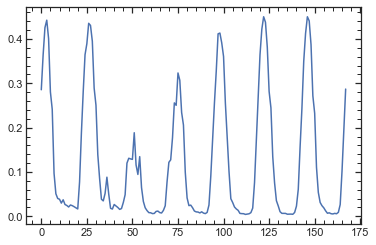

In [8]:
plt.plot(epot_hourly[:24*7])
plt.show()

## WCM

Frequency: multi-daily

Inputs:
- $\sigma^0$, $\theta$ (hourly, rounded to nearest midnight)
- vegetation descriptors (NDVI, LAI, CR) (average, daily)

In [9]:
#----------------------------------------------------------------------------
# Sigma0 values

# Freq: D
# Daily values of backscattering from 2014 to 2022 (complete S1 series)
# Data extracted:
# - sigma0 values, VV and VH
# - angle of incidence of reference orbit (nearest to 40°)

sigma_df = pd.read_csv('..\Data\\budrio-half.csv', delimiter='\t');
sigma_df['Datetime'] = sigma_df.Date.apply(lambda x : pd.to_datetime(x))
angle_mean_95 = sigma_df.loc[sigma_df.Orb==95]['Angle[°]'].mean()
sigma_df['Angle[°]'] = sigma_df['Angle[°]'].apply(lambda x : angle_mean_95)
sigma_df.Date = sigma_df.Date.apply(lambda x : pd.to_datetime(x).round(freq='D'))
sigma_df = sigma_df.set_index('Date')
if verbose: sigma_df.info()

In [10]:
#----------------------------------------------------------------------------
# NDVI values

# Freq: D
# Daily values of NDVI from 2017-4-24 to 2023-1-13 (complete S2 series)
# Data extracted:
# - NDVI (daily, interpolated)

ndvi_df = pd.read_csv('..\Data\\budrio-half_NDVI_discrete.csv', delimiter='\t');
ndvi_df.Date = ndvi_df.Date.apply(lambda x : pd.to_datetime(x))
ndvi_df = ndvi_df.set_index('Date')
ndvi_df = ndvi_df.resample('H').asfreq().interpolate(method='linear')
if verbose: ndvi_df.info()

# Input data

In [11]:
# Input SWB
# Frequency: daily
# Data:
# - rain (sum, end of day) from platinum_resampled
# - eto (daily) from eto_df

if freq=='d':
    input_swb = pd.merge(right=eto_df, left=platinum_resampled.sum(),
                     right_on='Date', left_on='Datetime', right_index=True)\
                    .drop(['SWC[m3/m3]','Temperatura[°C]'], axis=1)
    input_swb['SWC[m3/m3]'] = platinum_resampled.mean()['SWC[m3/m3]']
    if verbose: input_swb.info()

# Input SWB
# Frequency: hourly
# Data:
# - rain (hourly) from platinum_df, linear interpolation
# - irrigation (hourly) from platinum_df
# - eto (daily) from eto_df, up-resampled hourly with linear interpolation

elif freq=='h':
    # eto_df_h = eto_df.resample('H').asfreq().interpolate(method='linear')
    eto_df_h = pd.DataFrame(timeseries(t, epot_hourly)).rename(columns={0:'Datetime', 1:'EPOT'})
    eto_df_h.set_index('Datetime')
    input_swb = pd.merge(right=eto_df_h, left=platinum_df,
                         on='Datetime',)\
                        .drop(['Temperatura[°C]'], axis=1)
    input_swb.set_index('Datetime', inplace=True)
    input_swb['Pioggia[mm]'].interpolate(method='linear',inplace=True)
    input_swb['EPOT'].interpolate(method='linear',inplace=True)
    if verbose: input_swb.info()

In [12]:
# Input WCM
# Frequency: daily
# Data:
# - sigma0 (multi-daily, rounded at nearest midnight)
# - NDVI (daily, interpolated)
# Merging is performed without any time offset, considering that the change
# in ndvi values anywhere is very small from one day to another 

input_wcm_sat = pd.merge(right=sigma_df, left=ndvi_df, on='Date', how='right')
input_wcm_sat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NDVI         916 non-null    float64       
 1   Geometry_x   0 non-null      object        
 2   Angle[°]     1150 non-null   float64       
 3   Geometry_y   1150 non-null   object        
 4   Orb          1150 non-null   int64         
 5   Pass         1150 non-null   object        
 6   VV_norm[dB]  1150 non-null   float64       
 7   VH_norm[dB]  1150 non-null   float64       
 8   CR           1150 non-null   float64       
 9   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 98.8+ KB


In [13]:
input_wcm = pd.merge(right=input_wcm_sat, left=platinum_df, on='Datetime',
                     how='inner')\
            .drop(['Pioggia[mm]','Irrigazione[mm]','Temperatura[°C]',
                   'Geometry_x'], axis=1)\
            .rename(columns={'SWC[m3/m3]':'SWC_h', 'Geometry_y':'Geometry',
                             'VV_norm[dB]':'VV', 'VH_norm[dB]':'VH', 'Angle[°]':'Angle'})

#----------------------------------------------------------------------------
# Convenience method for printing labels of columns that are interpolated
# only on the basis of their length being less than the length of the df,
# and not taking into consideration if they are being interpolated or extr

# print('The following columns will be interpolated: '
#       +f'{[x for x in input_wcm if len(input_wcm[x].dropna())<len(input_wcm)]}\n')
# if input('Proceed? [y/n]')!='y':
#      raise NameError('Stop and stare! I think I\'m going but I don\'t know where!')
#----------------------------------------------------------------------------

print(
    '\nNDVI values are limited below at the 24 of april 2017, so they are'+
    'backward propagated for 30 days in order to cover the whole Budrio period.'+
    ' There is a gap in SWC values: this gap is not interpolated but is used to'+
    'eliminate those days with nan SM values from the days of passage of the'+
    'satellite.\n'
)
input_wcm.NDVI.interpolate(method='bfill',
                           limit_direction='backward',
                           limit=30,
                           # limit_area='inside', # THIS WORKS VERY BADLY IN EVERY WAY
                           inplace=True)
if freq=='d': input_wcm.index = input_wcm.Datetime.round('D')
elif freq=='h': input_wcm.index = input_wcm.Datetime
input_wcm.dropna(inplace=True)
if verbose: input_wcm.info()


NDVI values are limited below at the 24 of april 2017, so they arebackward propagated for 30 days in order to cover the whole Budrio period. There is a gap in SWC values: this gap is not interpolated but is used toeliminate those days with nan SM values from the days of passage of thesatellite.



In [14]:
# List of 2017 and 2020 dates

# Complete hours in 2017, 2020
t = [x for x in input_swb.index if x.year==year]
     
# Hours of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
t_sat = [x for x in intersect if x.year==year]

In [15]:
P       = input_swb.loc[t]['Pioggia[mm]'].values # [mm]
IRR_obs = input_swb.loc[t]['Irrigazione[mm]'].values # [mm]
EPOT    = input_swb.loc[t]['EPOT'].values # [mm/day]
WW_obs  = input_swb.loc[t]['SWC[m3/m3]'].values # daily mean or hourly, with gaps
WW_sat  = input_wcm.loc[t_sat]['SWC_h'].values # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[t_sat]['NDVI'].values # [-]
angle   = input_wcm.loc[t_sat]['Angle'].values # [°]
VV      = input_wcm.loc[t_sat]['VV'].values # [dB]
VH      = input_wcm.loc[t_sat]['VH'].values # [dB]
CR      = input_wcm.loc[t_sat]['CR'].values # [-]
Kc_array= Kc_curve(year, t)

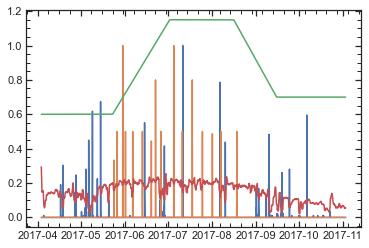

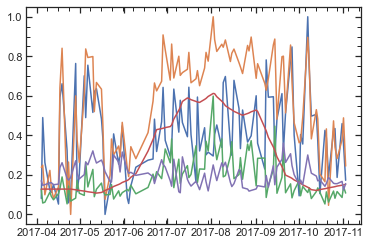

In [16]:
for x in [P,IRR_obs]: plt.plot(t, norm_simple(x));
plt.plot(t, Kc_array)
plt.plot(t, savgol_filter(EPOT, window_length=24, polyorder=1, mode='interp'))
plt.show()
for x in [norm_simple(VV),norm_simple(VH),CR,veg,WW_sat]: plt.plot(t_sat,x)
plt.show()

# Calibration SWB+WCM

In [17]:
# Calibration SWB+WCM

print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')


A      = 0.3
B      = 1.5
C      = -15
D      = 30    # guess params for WCM
d_0    = 100;  # [mm] water content, maximum (not normalized)
WW_fc  = 0.32; # [m3/m3] water content at field capacity
WW_w   = 0.09; # [m3/m3] water content at wilting point
rho_st = 0.4 if year==2017 else 0.5;  # [-] crop specific depletion fraction
Kc0    = 1;    # [-] crop specific coefficient
freq   = 6     # [GHz] frequency for DoI computation
d_0    = 1     # [-] scaling factor for depth of investigation

# PAR default
# PAR_str = [r'$A$', r'$B$', r'$C$', r'$D$', r'$\delta_0$', r'$W_{fc}$', r'$W_w$', r'$\rho_{st}$', r'$K_{c0}$']
PAR_str = [r'$A$', r'$B$', r'$C$', r'$D$', r'$\delta_0$', r'$W_{fc}$', r'$W_w$', r'$\rho_{st}$', r'$K_{c0}$']

# PAR to calibrate
# A, B, C, D, d_0, WW_fc, WW_w, rho_st, Kc0
PAR     = [A, B, C, D, d_0, WW_fc, WW_w, rho_st, Kc0]
PARn_str= [r'$A$', r'$B$', r'$C$', r'$D$', r'$\delta_0$', r'$W_{fc}$', r'$W_w$', r'$\rho_{st}$', r'$K_{c0}$']
inputs  = [t, t_sat, P, IRR_obs, EPOT, Kc_array,
           WW_obs, WW_sat, veg, angle, VV, freq]
user_in = [irri, units]

bounds = (
    np.array([0, 0, -30,  10, 1, 0.2, 0.07, 0.1, 0]), # low
    np.array([5, 3,  -5, 100, 2, 0.4, 0.17, 0.8, 2]), # up
)

optim='global'
options = {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
oh_strategy = {"w":'exp_decay', 'c1':'lin_variation', 'c2':'lin_variation'}

Starting calibration...
#-------------------------------------------------------------



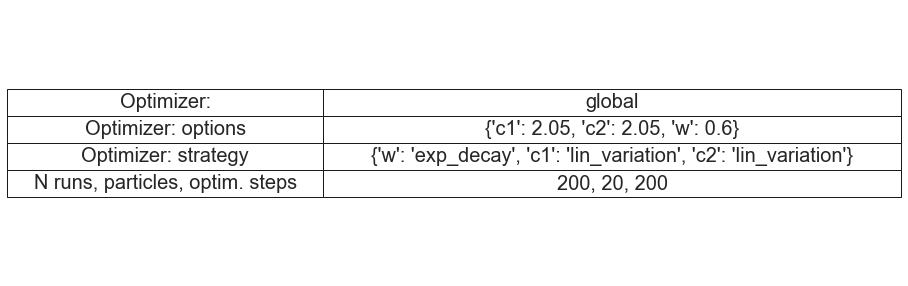

In [18]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with machine params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(14,5))
row_height=0.1; col_width=0.7

# Table with machine, inputs params
timing = 'daily' if freq=='d' else 'hourly'
calib = 'sigma0' if opt_calib=='1' else 'sigma0+sm'
nruns = str(nrun)
n_particles = 20
n_step = 200
cellText = [
    # ['Units', units],
    # ['Cost function', opt_cost],
    # ['Calib on', calib],
    ['Optimizer:', optim],
    ['Optimizer: options', options],
    ['Optimizer: strategy', oh_strategy],
    ['N runs, particles, optim. steps', str(nrun)+', '+str(n_particles)+', '+str(n_step)],
    # ['Time frequency', timing],
    # ['Vegetation descriptor', opt_veg],
]
table = ax.table(cellText=cellText,
                     cellLoc='center', loc='center',
                     colLabels=None, rowLabels=None)

for (row, col), cell in table.get_celld().items():
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_str))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{year}_table_mach.png', dpi=100)
plt.show()

# Parameters' study

In [23]:
# Retrieve PAR_dict from data 

PAR_dict_2017_FB_1 ={
r'$A$':['$[-]$', 'cal', [0.0, 5.0], 0.32, 0.104, np.array([1.00986331, 0.35670685, 0.34281463, 0.34499976, 0.32590418,
       0.36743281, 1.8142304 , 0.35025449, 3.17192156, 1.26422469,
       0.33480873, 0.36548279, 0.35274021, 2.54676387, 0.36876871,
       0.62615252, 0.34257866, 0.33419387, 0.33900528, 0.34559964,
       0.32882765, 0.33523298, 0.34303414, 0.33645197, 0.35217345,
       0.33629713, 0.34856312, 0.31953883, 0.34602858, 0.35750842,
       0.94796362, 2.16143016, 0.33407089, 0.33207669, 0.32751377,
       0.34433425, 0.34971829, 0.35817205, 0.33831588, 0.35792275,
       0.34452237, 0.40129216, 0.37576977, 0.34844528, 0.57214897,
       0.38867286, 0.33413664, 0.38902728, 0.34976184, 0.38903435,
       0.36110988, 0.37610395, 0.34039463, 0.39153956, 0.35240458,
       0.34269417, 3.20121617, 0.40169604, 0.35352017, 0.37205818,
       0.35025848, 0.39725706, 0.34683258, 0.34981102, 0.42620762,
       0.36279728, 0.34729537, 0.92220919, 0.35204082, 2.44246544,
       0.35267462, 0.33657446, 0.60568681, 0.33725454, 0.34982335,
       0.37305311, 0.34730034, 0.38065499, 0.34176982, 0.35629608,
       0.3373617 , 0.33615079, 0.34186678, 0.46872386, 0.35138875,
       1.57583562, 0.34883306, 0.33505173, 3.40878254, 2.37911738,
       0.34497842, 0.36854737, 0.34430256, 1.81386975, 0.35260739,
       0.35265395, 0.35441047, 0.35359572, 0.48295386, 0.32868956])],
r'$B$':['$[-]$', 'cal', [0.0, 3.0], 0.66, 0.101, np.array([0.1074564 , 0.66476045, 0.74156101, 0.78727742, 0.85033974,
       0.63219286, 0.05547271, 0.71256163, 0.03306031, 0.08424647,
       0.79179045, 0.61942895, 0.71004228, 0.0374546 , 0.65121187,
       0.20921903, 0.7845148 , 0.8453902 , 0.83191766, 0.67143869,
       0.84890367, 0.74821339, 0.83258202, 1.24742953, 0.76581924,
       0.75250406, 0.72509142, 0.94959648, 0.74601686, 0.65944081,
       0.1179877 , 0.04394869, 0.80957679, 0.82830153, 0.78803991,
       0.71788509, 0.70605249, 0.6797463 , 0.85215327, 0.65471425,
       0.78101754, 0.5044295 , 0.58019565, 0.7182062 , 0.237431  ,
       0.56648976, 0.83553873, 0.57512173, 0.76397212, 0.48491044,
       0.63917028, 0.59145175, 0.6893669 , 0.54589687, 0.72859207,
       0.79376355, 0.02850217, 0.52926817, 0.68855674, 0.58313006,
       0.71977078, 0.49751452, 0.74557808, 0.71948772, 0.43239362,
       0.5806308 , 0.7469186 , 0.12140552, 0.71593179, 0.03872905,
       0.69388286, 0.79574632, 0.25838932, 0.76280459, 0.7372773 ,
       0.57581225, 0.70387675, 0.5831169 , 0.79538499, 0.71104998,
       0.85669974, 0.75082594, 0.74685154, 0.33464826, 0.68031498,
       0.06713216, 0.69507414, 0.91830854, 0.02553613, 0.0401889 ,
       0.83033741, 0.63487611, 0.79090964, 0.05515559, 0.71169439,
       0.73861204, 0.67749011, 0.72881848, 0.31741569, 0.83768845])],
r'$C$':['$[dB]$', 'cal', [-30.0, -5.0], -16.13, 1.457, np.array([-15.27839395, -16.15877349, -15.59663168, -24.86736973,
       -14.94659573, -20.58658823, -17.93575371, -18.08592064,
       -26.63907611, -15.58272356, -14.45869029, -15.30526839,
       -16.25571612, -14.42451963, -17.63908787, -15.56334008,
       -16.23809877, -15.44074798, -14.39955222, -14.50196927,
       -17.78915325, -13.91219766, -15.48542655, -13.93952621,
       -15.09272795, -14.21266101, -16.86364911, -14.59170544,
       -16.4207023 , -14.29878871, -14.86719196, -18.56940396,
       -16.77880216, -18.3168878 , -14.97492803, -17.37501088,
       -17.93701152, -15.37868355, -14.79954417, -15.91435704,
       -21.48269299, -15.63551214, -15.97605965, -22.80880387,
       -15.66017607, -14.69673468, -15.10028075, -19.61496437,
       -16.51641964, -14.36042348, -16.28813218, -15.5658967 ,
       -14.32146911, -16.47033125, -16.3227425 , -17.93700828,
       -15.69383414, -15.28346542, -15.81980243, -14.92398491,
       -17.83482606, -15.00958062, -19.2525288 , -20.46282982,
       -16.5512213 , -16.34704542, -15.75762445, -16.03167531,
       -18.17285757, -15.02902729, -15.69916804, -15.60206456,
       -18.87260899, -17.78967434, -17.12491356, -16.13189747,
       -15.71329755, -17.47860386, -21.03117639, -14.6935199 ,
       -20.74346416, -14.93384923, -14.63300085, -16.23402203,
       -16.46892269, -19.74399732, -17.33671106, -24.27482929,
       -14.42367192, -15.37825184, -20.42069014, -15.49270067,
       -15.21831715, -16.12865   , -23.87506124, -16.48284254,
       -15.75655467, -15.94374143, -15.01930902, -16.51832211])],
r'$D$':['$[dB m^3/m^3]$', 'cal', [10.0, 100.0], 29.537, 9.811, np.array([28.28472025, 31.92289254, 32.79508917, 80.87310481, 25.11399842,
       71.89318746, 44.20122571, 44.72655498, 84.14583419, 42.87758872,
       30.64627962, 38.12852977, 38.92017651, 20.67531808, 46.36318633,
       32.48120795, 45.48792123, 41.11815971, 23.69233962, 33.15365467,
       48.51477942, 34.97741152, 30.36823857, 38.09362233, 29.44245155,
       23.5040403 , 46.76781427, 26.68897729, 38.39626862, 23.96626229,
       22.58438043, 37.76205373, 31.98215783, 52.33082054, 38.52903712,
       49.60890609, 54.67442659, 34.84358291, 38.52525757, 31.2032508 ,
       72.55222281, 38.41029684, 28.73037166, 66.40576629, 26.56960632,
       31.90110796, 26.8193345 , 47.01291698, 36.91408654, 34.56560287,
       43.93386067, 30.29496281, 25.03262484, 46.17724004, 34.97616168,
       40.01397851, 26.74189686, 30.02896771, 34.5390131 , 25.9920699 ,
       47.49267786, 30.1843084 , 60.83162015, 53.71339914, 36.6793736 ,
       37.78218733, 39.57161078, 26.33332485, 46.57939508, 27.23590582,
       31.02366343, 34.20948225, 42.30710051, 59.18575808, 46.64659728,
       29.83290392, 33.93913775, 39.41479757, 57.12980346, 27.50247211,
       54.13140777, 27.11251407, 29.94708559, 29.1591869 , 32.88283945,
       61.75279459, 37.17020691, 73.92009413, 32.12560191, 30.83398461,
       57.13732745, 36.07945906, 30.38660866, 28.57888606, 75.00014332,
       42.37732662, 27.02538128, 35.43161389, 23.79947002, 43.45150842])],
r'$\delta_0$':['$[mm]$', 'cal', [1.0, 2.0], 1.0, 0.004, np.array([1.00035327, 1.00761376, 1.01105548, 1.07575237, 1.00429183,
       1.09379177, 1.02335274, 1.00017161, 1.03118673, 1.00072182,
       1.00006382, 1.00414376, 1.00167663, 1.00000492, 1.00089   ,
       1.00018973, 1.0088299 , 1.03909809, 1.00276098, 1.06822323,
       1.00153888, 1.00723498, 1.00060125, 1.00278539, 1.03248556,
       1.00401818, 1.07400587, 1.02575994, 1.0328516 , 1.00122009,
       1.00103506, 1.00050676, 1.04674112, 1.00267274, 1.00397873,
       1.02743989, 1.11282151, 1.0321583 , 1.00926169, 1.00183808,
       1.20104254, 1.00071594, 1.01142336, 1.00949489, 1.00020399,
       1.01191652, 1.00078662, 1.00396432, 1.00002302, 1.00852787,
       1.00720155, 1.00880058, 1.00778184, 1.00232374, 1.00010265,
       1.01613189, 1.00023715, 1.00030811, 1.00000242, 1.08428371,
       1.14742735, 1.00410342, 1.00099549, 1.00177589, 1.01059188,
       1.00868785, 1.00675958, 1.01734603, 1.00050512, 1.00056914,
       1.00154372, 1.00009954, 1.00219832, 1.00381698, 1.03383003,
       1.00010491, 1.03413316, 1.00905971, 1.32364523, 1.00089527,
       1.00334066, 1.13619718, 1.00349702, 1.00208951, 1.00000731,
       1.02565583, 1.00072703, 1.02851035, 1.00017754, 1.00048726,
       1.05367103, 1.00124308, 1.00152449, 1.01366466, 1.21485186,
       1.00032801, 1.00087684, 1.00794959, 1.00721477, 1.01198604])],
r'$W_{fc}$':['$[m^3/m^3]$', 'cal', [0.2, 0.4], 0.283, 0.087, np.array([0.32086908, 0.34294344, 0.32125154, 0.23894151, 0.39874469,
       0.2128796 , 0.2576624 , 0.2922285 , 0.2314251 , 0.21929664,
       0.31068543, 0.2661148 , 0.28765451, 0.38717844, 0.26748377,
       0.29279616, 0.24540516, 0.25091571, 0.39811146, 0.2741187 ,
       0.26569345, 0.24693069, 0.35125774, 0.25939845, 0.34416498,
       0.38849717, 0.25230401, 0.35285597, 0.29692127, 0.37918827,
       0.38727138, 0.32238586, 0.36947416, 0.25414513, 0.25141577,
       0.2380323 , 0.23544898, 0.29074936, 0.25890505, 0.34595643,
       0.22923609, 0.2652674 , 0.36987935, 0.25792117, 0.3663538 ,
       0.29340361, 0.3763884 , 0.29554061, 0.31127771, 0.24541035,
       0.25154611, 0.33363354, 0.35660513, 0.24139471, 0.32191192,
       0.32428274, 0.34764038, 0.3314709 , 0.30849534, 0.3692287 ,
       0.26894741, 0.3155305 , 0.23100557, 0.2778067 , 0.29816515,
       0.27880697, 0.26904001, 0.37490594, 0.28422452, 0.32364127,
       0.34144087, 0.31491186, 0.30026637, 0.21557355, 0.25820312,
       0.36270537, 0.3127307 , 0.31125282, 0.28014448, 0.35387532,
       0.2853741 , 0.3597704 , 0.32092276, 0.36288254, 0.34520587,
       0.2160351 , 0.32920471, 0.25672028, 0.2432315 , 0.29136716,
       0.26580055, 0.2883557 , 0.33601382, 0.34471217, 0.2456891 ,
       0.26918104, 0.39316563, 0.30726736, 0.38270812, 0.26474628])],
r'$W_w$':['$[m^3/m^3]$', 'cal', [0.07, 0.17], 0.103, 0.026, np.array([0.09721161, 0.11719743, 0.09160824, 0.15617151, 0.10610501,
       0.11586971, 0.11156967, 0.13535839, 0.1662662 , 0.07228889,
       0.09164202, 0.0841475 , 0.10649705, 0.09191336, 0.1100693 ,
       0.09155598, 0.08806124, 0.11472452, 0.07488183, 0.16141597,
       0.11188569, 0.1031782 , 0.11160268, 0.07057864, 0.09307289,
       0.09067783, 0.10371007, 0.11005561, 0.10535885, 0.09206959,
       0.11128028, 0.16460611, 0.14757773, 0.11326233, 0.12103241,
       0.15278871, 0.10718741, 0.09137007, 0.07630652, 0.12675867,
       0.13255755, 0.09126731, 0.12657065, 0.15920641, 0.13021891,
       0.08051262, 0.09363155, 0.14048192, 0.11244604, 0.15023135,
       0.09406142, 0.10888919, 0.15740145, 0.09309756, 0.11301832,
       0.14320425, 0.12083038, 0.0975611 , 0.09754034, 0.10957349,
       0.11736396, 0.09116953, 0.10984181, 0.15907055, 0.11591279,
       0.0905083 , 0.09062539, 0.14397269, 0.12987073, 0.10102053,
       0.10874779, 0.1011162 , 0.13753585, 0.09224605, 0.10663976,
       0.13593481, 0.10936945, 0.13722968, 0.15607293, 0.08588924,
       0.16385213, 0.10314956, 0.09280421, 0.1463247 , 0.13417117,
       0.11561901, 0.14030446, 0.16409959, 0.12414444, 0.08992393,
       0.12897735, 0.10030264, 0.08328574, 0.13187543, 0.15992367,
       0.09019896, 0.13240328, 0.1055928 , 0.12425581, 0.08811679])],
r'$\rho_{st}$':['$[mm/h]$', 'cal', [0.1, 0.8], 0.1, 0.129, np.array([0.21509381, 0.15557464, 0.13832651, 0.1231479 , 0.23698437,
       0.10414942, 0.11042131, 0.10208449, 0.1001575 , 0.23995187,
       0.39610739, 0.25279032, 0.20622144, 0.30072275, 0.11850841,
       0.21375199, 0.272908  , 0.41119812, 0.22252585, 0.47829354,
       0.12530025, 0.53672585, 0.20419284, 0.36831795, 0.25057729,
       0.35847563, 0.22943028, 0.4055338 , 0.15103962, 0.34229233,
       0.26392385, 0.12858037, 0.18581537, 0.11006767, 0.44751566,
       0.33453772, 0.17850745, 0.30131027, 0.32805875, 0.22617577,
       0.10041998, 0.26962822, 0.16834821, 0.14760188, 0.24155702,
       0.32925843, 0.16688807, 0.12689055, 0.16630979, 0.49782347,
       0.21911576, 0.29214611, 0.48370136, 0.21391724, 0.147     ,
       0.10348785, 0.23188289, 0.17274867, 0.1691515 , 0.28821595,
       0.13444364, 0.26530547, 0.10007617, 0.2064478 , 0.20760892,
       0.21698047, 0.27840466, 0.23247944, 0.10163729, 0.2686267 ,
       0.1660684 , 0.17381399, 0.10073549, 0.1416278 , 0.21735821,
       0.21530373, 0.26548128, 0.13801576, 0.10000004, 0.17542005,
       0.20284568, 0.31259893, 0.35045153, 0.23094066, 0.18567961,
       0.11232132, 0.13657292, 0.13395477, 0.49898374, 0.2436382 ,
       0.10395313, 0.30598946, 0.13909644, 0.21658219, 0.12063382,
       0.1403995 , 0.17333668, 0.21876698, 0.35638524, 0.13697905])],
r'$K_{c0}$':['$[-]$', 'cal', [0.0, 2.0], 0.242, 0.026, np.array([0.30396394, 0.25672067, 0.26333113, 0.09594083, 0.24556485,
       0.21791652, 0.23927673, 0.23031576, 0.07412255, 0.32251855,
       0.28227721, 0.28730557, 0.24806665, 0.31996211, 0.22851927,
       0.28227659, 0.22792472, 0.19244576, 0.26052548, 0.23310774,
       0.23144728, 0.23987437, 0.24847586, 0.28609583, 0.24594923,
       0.27396744, 0.25373037, 0.22594429, 0.25985759, 0.26301696,
       0.32345261, 0.24958052, 0.24406637, 0.21990221, 0.20709572,
       0.15200235, 0.25445196, 0.24699996, 0.26241373, 0.26301301,
       0.23833272, 0.26559225, 0.26462852, 0.10154424, 0.26904757,
       0.26119386, 0.2572193 , 0.15017061, 0.22664443, 0.23233333,
       0.25904646, 0.23467596, 0.22032431, 0.26144479, 0.2444075 ,
       0.2288934 , 0.29834922, 0.28116643, 0.26519947, 0.2886341 ,
       0.25862447, 0.29400613, 0.1993634 , 0.12296469, 0.25317417,
       0.22703699, 0.22933762, 0.27233165, 0.22841387, 0.32919015,
       0.26416434, 0.26975947, 0.18118222, 0.24857783, 0.23452707,
       0.25631252, 0.26636244, 0.25997015, 0.21934915, 0.28294096,
       0.11634004, 0.27203791, 0.27175279, 0.29275898, 0.25501506,
       0.22451585, 0.2513907 , 0.09478174, 0.23308075, 0.30878467,
       0.15731009, 0.22472508, 0.26209887, 0.28384004, 0.13601115,
       0.24262566, 0.26563446, 0.23752431, 0.27352063, 0.23890884])],
}
#----------------------------------------------------------------------------
PAR_dict_2017_FB_2 ={
r'$A$':['$[-]$', 'cal', [0.0, 5.0], 0.314, 0.143, np.array([0.3456671 , 3.22554715, 0.39749053, 0.37763534, 0.43369879,
       0.3426699 , 0.54826037, 0.35119973, 0.34423313, 0.85179913,
       1.33183018, 0.57601283, 0.34944018, 0.42147963, 0.36189056,
       0.4479473 , 0.33459094, 0.61224745, 0.3359066 , 0.58797038,
       0.33392366, 0.31722293, 0.36748867, 0.37067203, 2.3584402 ,
       2.87224402, 2.22958014, 0.37227526, 0.33869905, 0.89230399,
       0.33066798, 0.34872977, 0.35298478, 0.34768126, 3.70588116,
       0.32737692, 0.33268245, 0.78338767, 0.36056912, 0.3663733 ,
       0.34446074, 0.36364524, 2.24823101, 0.34519352, 0.33756194,
       0.34560022, 0.34625381, 0.31978027, 0.33718361, 0.38760076,
       1.30298437, 0.35487428, 0.68945855, 0.31881795, 0.36698809,
       0.41514684, 0.33784416, 0.32659745, 0.34043441, 0.34276383,
       0.41825357, 0.33252607, 0.3137765 , 0.33272858, 0.34198474,
       0.37284286, 0.33773676, 0.34256016, 0.42390043, 1.35938579,
       0.45051277, 0.38770588, 0.37539429, 0.32213728, 0.34940656,
       0.34819739, 0.32863594, 0.35232846, 0.34010952, 1.73895117,
       3.02506894, 0.33320997, 0.38937754, 0.34325229, 0.31646735,
       0.33526109, 0.34519535, 0.35838479, 0.3659282 , 1.26208613,
       0.39205803, 0.33767991, 0.32990739, 0.89766377, 0.349168  ,
       0.34226569, 0.36063164, 0.34215229, 0.359313  , 0.3510338 ])],
r'$B$':['$[-]$', 'cal', [0.0, 3.0], 0.67, 0.099, np.array([0.73809058, 0.02722945, 0.52297665, 0.58051418, 0.41294687,
       0.85638959, 0.26978975, 0.77094113, 0.69559941, 0.13888327,
       0.07724408, 0.23657531, 0.74281957, 0.48839285, 0.666232  ,
       0.38691829, 0.8648727 , 0.22261695, 0.76066215, 0.20652458,
       0.83263046, 1.02876826, 0.60825703, 0.59902743, 0.04114462,
       0.03007759, 0.04287343, 0.53965542, 0.75863099, 0.12053338,
       0.69428444, 0.77765238, 0.68974798, 0.7263752 , 0.02439314,
       1.0147972 , 0.82533625, 0.15678622, 0.6151834 , 0.61982378,
       0.75430678, 0.63226948, 0.04026021, 0.74261089, 0.77155806,
       0.76651338, 0.73076371, 1.13522982, 0.77209127, 0.53038739,
       0.07950686, 0.68798325, 0.18860364, 1.05885786, 0.60513286,
       0.43773232, 0.75160719, 0.94254075, 0.755326  , 0.74108592,
       0.43627207, 0.9015802 , 0.9581309 , 0.76987099, 0.7194003 ,
       0.58522596, 0.79733343, 0.77544876, 0.44627492, 0.07435832,
       0.37472436, 0.52457192, 0.52950377, 0.86238664, 0.71988533,
       0.71322288, 0.9899961 , 0.71757475, 0.78047212, 0.05602135,
       0.03088049, 1.00557662, 0.52670853, 0.79505637, 1.04764024,
       0.88266803, 0.80632093, 0.67339073, 0.59976533, 0.08390941,
       0.54777234, 0.78523978, 0.86754135, 0.1476528 , 0.73461962,
       0.69691503, 0.64438654, 0.70537325, 0.64664699, 0.68313114])],
r'$C$':['$[dB]$', 'cal', [-30.0, -5.0], -15.724, 2.026, np.array([-17.35809418, -15.95891268, -16.67930181, -15.52397932,
       -19.78357278, -19.88431782, -16.67543298, -14.89396225,
       -17.22299857, -15.81868307, -15.79925638, -14.86769906,
       -16.52195487, -14.45718027, -16.60990662, -17.96150861,
       -16.71512594, -16.20500721, -15.09765329, -15.5593456 ,
       -15.71036002, -22.94380036, -15.11134555, -15.89305641,
       -18.33353697, -14.62154696, -16.59399218, -14.15634696,
       -20.4186528 , -14.54077611, -16.71905456, -20.62376831,
       -16.98056831, -16.28029679, -15.49173164, -17.75226803,
       -15.9519093 , -16.72526908, -15.5865853 , -15.61841636,
       -14.95276113, -14.87417714, -15.17248629, -14.77095884,
       -17.28230781, -15.93470325, -14.44688075, -21.00213625,
       -15.75935373, -15.76701066, -14.89459695, -19.41976634,
       -17.57846262, -17.91977488, -21.67875555, -21.60277961,
       -15.09720599, -21.91500025, -19.60561416, -14.72365397,
       -14.73273819, -23.85755348, -14.28905151, -14.36782024,
       -15.3528097 , -16.08906606, -14.59622732, -15.84442537,
       -16.59228893, -15.5812589 , -14.89838177, -18.08655116,
       -14.55746744, -15.76350143, -16.18725065, -15.55590317,
       -18.72450946, -17.60613687, -15.7193904 , -14.74046275,
       -16.47842575, -18.45629291, -16.01883286, -17.26057153,
       -19.7500295 , -23.58846386, -21.02841069, -18.51936187,
       -15.4364804 , -16.52151684, -15.38595286, -15.22720221,
       -16.31809443, -26.03756754, -21.02770233, -14.47310783,
       -15.08794676, -15.05603456, -20.16848375, -14.852314  ])],
r'$D$':['$[dB m^3/m^3]$', 'cal', [10.0, 100.0], 27.816, 14.221, np.array([53.54446396, 25.79799793, 42.21593462, 35.19893269, 57.07650935,
       58.77372213, 37.17605565, 26.60827926, 44.31419166, 29.65973203,
       30.3969679 , 23.97820045, 38.74278977, 23.50148894, 36.72619409,
       41.72519692, 46.68876257, 33.73770688, 26.16509927, 25.6946099 ,
       33.83633657, 69.92842612, 34.11523744, 38.94536677, 53.88525421,
       26.87447062, 32.55797696, 28.97458485, 62.11148792, 34.57924895,
       39.75015291, 67.15020374, 36.42077986, 43.46918234, 24.08555979,
       49.30730361, 42.58315275, 41.17162944, 31.1364861 , 28.27132537,
       29.53653038, 32.46555768, 28.69097048, 28.63691409, 51.1742932 ,
       33.70820321, 27.26399193, 54.25363867, 32.12894693, 39.46142871,
       23.80812816, 53.22436929, 42.55511914, 48.12691364, 66.01457483,
       66.94168458, 32.76089534, 61.07531783, 62.12762115, 31.14619634,
       31.06627136, 85.92161483, 33.16626333, 33.76009766, 38.8984926 ,
       32.79571572, 24.59640746, 29.5068652 , 38.0945217 , 31.24742592,
       29.39686381, 61.32786028, 25.68765201, 44.41881643, 34.0584787 ,
       39.05012819, 48.74146247, 44.97403285, 31.03866063, 22.81801508,
       34.17893836, 52.46388713, 30.3984695 , 44.3431839 , 56.50537555,
       89.09644838, 71.55548604, 54.40662583, 30.99215778, 36.08578054,
       42.26089305, 31.84310871, 42.23273916, 88.71980831, 55.08147923,
       31.57557853, 28.95634483, 34.40424664, 51.32354957, 30.76905879])],
r'$\delta_0$':['$[mm]$', 'cal', [1.0, 2.0], 1.003, 0.005, np.array([1.01452574, 1.03162792, 1.02802162, 1.02491283, 1.00585629,
       1.01427587, 1.00016445, 1.0000656 , 1.00213017, 1.0019115 ,
       1.0000263 , 1.00270877, 1.00010825, 1.0131732 , 1.05446327,
       1.00003978, 1.00203421, 1.00015407, 1.00220048, 1.02639226,
       1.00075059, 1.00681986, 1.00396707, 1.00090204, 1.32300055,
       1.00425959, 1.01363648, 1.02255944, 1.11607003, 1.00369781,
       1.00472702, 1.00024619, 1.00212788, 1.03628461, 1.00704793,
       1.00321534, 1.00607546, 1.0002055 , 1.00052307, 1.0000254 ,
       1.00582641, 1.0264164 , 1.00426565, 1.00386013, 1.13696766,
       1.00096753, 1.05427706, 1.00211177, 1.02935013, 1.00022541,
       1.00066055, 1.4357814 , 1.00183814, 1.01981501, 1.08954835,
       1.00825871, 1.00982069, 1.01887948, 1.02222271, 1.00188424,
       1.011042  , 1.01305332, 1.00314521, 1.00091831, 1.01485957,
       1.00009285, 1.00201942, 1.04009333, 1.0122329 , 1.00361804,
       1.01576926, 1.11686782, 1.00119493, 1.00026187, 1.01329642,
       1.00036107, 1.00188395, 1.00441863, 1.00072224, 1.0007063 ,
       1.07139384, 1.00538698, 1.00139771, 1.00033767, 1.04729927,
       1.01526725, 1.01193392, 1.12541402, 1.0077657 , 1.00029314,
       1.01526107, 1.00037837, 1.00190121, 1.14718401, 1.00867346,
       1.0279556 , 1.00047499, 1.15281659, 1.136453  , 1.00004348])],
r'$W_{fc}$':['$[m^3/m^3]$', 'cal', [0.2, 0.4], 0.276, 0.049, np.array([0.22940726, 0.37394168, 0.2684501 , 0.2901725 , 0.24751246,
       0.25215398, 0.28671613, 0.37117461, 0.27321472, 0.32712381,
       0.31172734, 0.36698389, 0.29721931, 0.38278635, 0.31081981,
       0.29352029, 0.24525508, 0.30068794, 0.38375522, 0.36208145,
       0.31854488, 0.25964695, 0.28899022, 0.27093634, 0.22448884,
       0.29280686, 0.31274075, 0.29207364, 0.24768361, 0.24539299,
       0.27648355, 0.22673392, 0.32619665, 0.25946809, 0.37796867,
       0.26620662, 0.25999035, 0.2554815 , 0.33289016, 0.366905  ,
       0.33565406, 0.29437904, 0.30902751, 0.3404757 , 0.24231537,
       0.32640613, 0.34661371, 0.29849969, 0.33384981, 0.25969058,
       0.3636242 , 0.26897886, 0.26964477, 0.27682239, 0.24953805,
       0.22840245, 0.30412095, 0.27444922, 0.23285366, 0.30963464,
       0.29623711, 0.21706159, 0.28556448, 0.26925327, 0.25479736,
       0.32716803, 0.39314274, 0.36775627, 0.28750533, 0.29600162,
       0.30645315, 0.20826553, 0.3502463 , 0.24533313, 0.32587562,
       0.26720037, 0.28455948, 0.27720468, 0.34623627, 0.37529845,
       0.29403175, 0.26481084, 0.34773621, 0.27729448, 0.2686548 ,
       0.20514672, 0.21722238, 0.24587924, 0.32861843, 0.28358025,
       0.2351733 , 0.32219782, 0.26275626, 0.21895725, 0.28048687,
       0.28680011, 0.33513061, 0.2807261 , 0.29056288, 0.31354385])],
r'$W_w$':['$[m^3/m^3]$', 'cal', [0.07, 0.17], 0.105, 0.015, np.array([0.09346022, 0.1426137 , 0.10266381, 0.09091231, 0.12980491,
       0.11989636, 0.1109361 , 0.10894892, 0.11223199, 0.1152715 ,
       0.10623522, 0.09691575, 0.11320281, 0.10312145, 0.11814192,
       0.1335961 , 0.099415  , 0.11207754, 0.10586145, 0.1156231 ,
       0.09695261, 0.15775155, 0.08874621, 0.08767683, 0.11420069,
       0.12383846, 0.12532275, 0.08854172, 0.13333384, 0.14309076,
       0.07363126, 0.13149269, 0.13438499, 0.10216899, 0.12429484,
       0.10316304, 0.09276187, 0.10239055, 0.1091018 , 0.11716254,
       0.10139125, 0.08245666, 0.10458781, 0.10254051, 0.10369736,
       0.10848919, 0.09413358, 0.16514845, 0.10875083, 0.08600604,
       0.102768  , 0.13639514, 0.11716259, 0.11075739, 0.14785508,
       0.14431237, 0.09996591, 0.16160839, 0.11465468, 0.08995291,
       0.0838118 , 0.13087604, 0.11857595, 0.10530728, 0.11587552,
       0.11126323, 0.0979243 , 0.11956554, 0.10328293, 0.10311706,
       0.08860717, 0.09732426, 0.13618351, 0.07971287, 0.11287583,
       0.08335475, 0.11818859, 0.11362472, 0.10953945, 0.10781014,
       0.11555105, 0.1192543 , 0.11724771, 0.11165178, 0.1360143 ,
       0.14103522, 0.11601889, 0.11292733, 0.11225751, 0.11268003,
       0.07338573, 0.09157131, 0.14754278, 0.15303999, 0.15915203,
       0.11296551, 0.08985597, 0.11396394, 0.15669328, 0.0927787 ])],
r'$\rho_{st}$':['$[mm/h]$', 'cal', [0.1, 0.8], 0.1, 0.137, np.array([0.15748925, 0.2286355 , 0.14494251, 0.24278349, 0.1058062 ,
       0.10245109, 0.17570092, 0.31322752, 0.15993848, 0.19655003,
       0.19428628, 0.23285929, 0.19255879, 0.37173937, 0.15534212,
       0.11233722, 0.34885179, 0.21546525, 0.18487534, 0.19480052,
       0.18796396, 0.11122902, 0.29579563, 0.20693157, 0.18814492,
       0.4824566 , 0.19991176, 0.51531296, 0.10070556, 0.44609121,
       0.31552206, 0.21091946, 0.15236935, 0.26107825, 0.21933508,
       0.10097517, 0.25413888, 0.2120959 , 0.20919069, 0.18224987,
       0.32085377, 0.32169797, 0.34544044, 0.34208305, 0.18894325,
       0.14785911, 0.35288044, 0.18058197, 0.21624812, 0.25890308,
       0.25685914, 0.10762807, 0.13114841, 0.10801886, 0.10077211,
       0.18160613, 0.34221964, 0.18031072, 0.10769906, 0.34293348,
       0.30487333, 0.10170112, 0.46898697, 0.49130775, 0.4255331 ,
       0.16407005, 0.22554337, 0.15558455, 0.13105977, 0.29577066,
       0.34049805, 0.149705  , 0.4548748 , 0.21418204, 0.15818429,
       0.22232194, 0.10082895, 0.12388441, 0.15339357, 0.26929345,
       0.20496525, 0.12953645, 0.16467745, 0.13401286, 0.10008496,
       0.15821041, 0.1966873 , 0.10106502, 0.27143553, 0.20781334,
       0.23165685, 0.22337261, 0.37355951, 0.10085546, 0.18718038,
       0.4807975 , 0.28075698, 0.43574481, 0.1009029 , 0.33487865])],
r'$K_{c0}$':['$[-]$', 'cal', [0.0, 2.0], 0.248, 0.033, np.array([0.24498064, 0.3083993 , 0.27576553, 0.26011733, 0.2116499 ,
       0.16709993, 0.24918027, 0.24447117, 0.25156167, 0.28969617,
       0.30324302, 0.30031326, 0.24103986, 0.25423727, 0.26439023,
       0.23252915, 0.15598327, 0.2565847 , 0.27330168, 0.28840632,
       0.25195022, 0.13595352, 0.28278081, 0.25402238, 0.31981325,
       0.22031262, 0.2751364 , 0.23721828, 0.22403409, 0.22529408,
       0.14353933, 0.11698908, 0.25314184, 0.26555861, 0.30830002,
       0.20942056, 0.25411793, 0.25717508, 0.27603186, 0.27419944,
       0.25160386, 0.25934385, 0.31937985, 0.26530611, 0.28497521,
       0.26525893, 0.2833406 , 0.112592  , 0.26007558, 0.24873942,
       0.31566283, 0.28774373, 0.25268088, 0.2165793 , 0.21761835,
       0.11231313, 0.2683246 , 0.10987358, 0.20408822, 0.26717302,
       0.28988089, 0.12209478, 0.20826521, 0.22124839, 0.18998284,
       0.26077988, 0.27978219, 0.26091977, 0.25578619, 0.28500292,
       0.26838492, 0.28954585, 0.22815134, 0.25813403, 0.26060934,
       0.26574255, 0.17156821, 0.22992765, 0.26348651, 0.3276013 ,
       0.29424331, 0.20365388, 0.26264063, 0.23829149, 0.20932938,
       0.10330383, 0.11616093, 0.25259556, 0.26527132, 0.2772172 ,
       0.28233536, 0.2637729 , 0.16449362, 0.09172271, 0.11532947,
       0.21950306, 0.23817076, 0.22401472, 0.22972912, 0.26117167])],
}
#----------------------------------------------------------------------------
PAR_dict_2020_FB_1 ={
r'$A$':['$[-]$', 'cal', [0.0, 5.0], 0.176, 0.157, np.array([0.17910762, 0.19249792, 0.17860682, 0.66407713, 0.58225438,
       0.19409844, 0.19914654, 2.5743287 , 0.2135463 , 0.18457483,
       0.1773659 , 0.18027992, 0.26252944, 0.21777717, 1.5588313 ,
       0.19350304, 0.18739286, 1.73045062, 0.20867538, 0.54772693,
       0.18242379, 0.20216194, 0.20085482, 0.34363779, 1.04645796,
       0.20230397, 0.1758226 , 2.22930004, 0.29690547, 0.22002393,
       0.20723163, 0.20811855, 0.30327143, 0.1818478 , 0.3293906 ,
       0.19819394, 0.19597493, 0.17826767, 0.19094262, 1.94858707,
       0.18295209, 0.37253957, 4.17707887, 0.4023854 , 0.20221141,
       1.96660714, 0.18987225, 0.23532842, 0.18280884, 1.16610229,
       0.29009316, 0.21492845, 0.17957601, 0.22814809, 0.20923886,
       0.18046339, 0.27930785, 0.24734358, 0.22601007, 3.46409663,
       0.1789021 , 2.55269023, 0.21479538, 0.1829844 , 0.19492794,
       0.17902313, 0.73336642, 1.5574209 , 2.99829642, 0.18589455,
       1.13817762, 0.29310477, 0.22001818, 0.17690194, 0.18537534,
       0.38014897, 0.20943327, 1.66899762, 0.18309267, 0.17633234,
       0.18360949, 0.22901372, 2.7260396 , 0.18032265, 0.22935235,
       0.20920886, 0.20148808, 0.20823766, 0.18374878, 1.77265384,
       0.22629823, 0.18330668, 1.14253173, 0.17949362, 0.18396326,
       2.76803258, 0.17854333, 1.01836084, 0.18390232, 0.18481962])],
r'$B$':['$[-]$', 'cal', [0.0, 3.0], 0.016, 0.685, np.array([2.09422982, 0.73451086, 2.81004182, 0.09586521, 0.11339005,
       0.69353812, 0.71576653, 0.0245567 , 0.59446369, 2.50553167,
       1.62560171, 1.08626509, 0.42902591, 0.65628165, 0.035847  ,
       0.89559074, 0.99425617, 0.03124248, 0.64045452, 0.12170065,
       0.96182178, 0.73444485, 0.76341537, 0.25084647, 0.05655159,
       0.72124115, 0.91537919, 0.02523121, 0.2743209 , 0.53285312,
       0.59620312, 0.63540498, 0.27897187, 1.69977604, 0.23980913,
       0.80616027, 0.71362896, 1.8321793 , 0.76690483, 0.0359741 ,
       0.77989375, 0.21181742, 0.01661455, 0.1760585 , 0.72125434,
       0.02917188, 1.0133947 , 0.45914648, 1.65496901, 0.06247138,
       0.31457018, 0.57907983, 1.09785912, 0.50477551, 0.72490556,
       1.82912874, 0.31757461, 0.42411419, 0.49565098, 0.01642197,
       2.53454598, 0.02187611, 0.57837129, 1.01962581, 0.7104278 ,
       0.97443019, 0.10429599, 0.03788626, 0.02306157, 0.97834942,
       0.04841682, 0.29187072, 0.48662526, 2.2952317 , 0.72585318,
       0.20724   , 0.61796902, 0.03663701, 1.43374188, 1.1712773 ,
       1.56247738, 0.58187391, 0.02024578, 1.79714108, 0.58117847,
       0.59022426, 0.7391134 , 0.59014098, 2.11183904, 0.03162094,
       0.47833845, 1.27225321, 0.06256169, 2.01289124, 2.84231919,
       0.0199045 , 1.81438377, 0.05837053, 0.78784529, 1.2376887 ])],
r'$C$':['$[dB]$', 'cal', [-30.0, -5.0], -19.898, 2.22, np.array([-25.91828554, -20.78531847, -24.39537247, -19.90195089,
       -21.91032974, -20.93759265, -19.20247454, -22.10194431,
       -21.3217899 , -17.58195744, -28.07578274, -19.3595048 ,
       -23.65927698, -24.81885926, -18.32422439, -23.57646736,
       -18.65801351, -18.99169673, -17.63144892, -19.2695536 ,
       -20.56465907, -22.16916787, -19.55521598, -18.43632619,
       -19.10310152, -19.10512963, -21.97262122, -18.42302496,
       -19.84983111, -20.05255279, -22.83003167, -19.97400871,
       -17.10901804, -18.73598677, -18.25141152, -19.01515974,
       -20.60390261, -18.85604703, -24.58979237, -24.34782895,
       -23.04717519, -22.80867497, -24.41235734, -18.95487913,
       -19.14637739, -18.46991166, -18.42915532, -22.03547556,
       -18.43868871, -28.74545307, -21.48592374, -25.08426801,
       -21.59474845, -21.46259986, -17.47233261, -16.3909707 ,
       -18.43807228, -24.28203808, -20.10877494, -17.88766637,
       -25.83690813, -17.76386027, -20.00696298, -18.7425213 ,
       -21.56126568, -20.08451719, -25.25561462, -16.90780487,
       -23.3016661 , -19.99021263, -20.60086061, -20.75685442,
       -25.88466874, -20.22589871, -18.69855235, -20.14894801,
       -19.00809535, -17.82847042, -18.24676594, -26.53794951,
       -18.20721027, -29.47320375, -18.37028622, -21.63359449,
       -19.26511758, -18.4979677 , -19.93352122, -23.52552076,
       -18.33862493, -16.97472131, -18.92004431, -19.48592043,
       -26.41159951, -17.68309434, -17.80711849, -18.88348453,
       -20.83082634, -21.94119983, -24.13022925, -16.65998478])],
r'$D$':['$[dB m^3/m^3]$', 'cal', [10.0, 100.0], 39.502, 16.206, np.array([70.97231945, 54.08755526, 60.46902883, 42.91957336, 48.599756  ,
       36.59687866, 43.15382253, 45.16105151, 39.00078819, 52.59294209,
       72.72870484, 60.03140137, 53.36625454, 47.09231813, 43.12225648,
       42.20291635, 50.81225192, 38.79268306, 29.58959257, 38.36863223,
       64.19166833, 48.93549332, 37.77443987, 27.81356068, 30.65295111,
       30.80191941, 68.25587549, 41.51652668, 47.69419015, 44.03008129,
       68.08096861, 33.2080736 , 23.71889662, 64.29618397, 30.70330548,
       38.07352668, 39.98092739, 44.01025673, 67.89498356, 44.54785541,
       66.40129239, 39.03336326, 36.10863523, 34.01196138, 49.68400369,
       27.68233428, 39.99710576, 45.25017722, 63.4177111 , 73.71596774,
       34.1856406 , 58.97432574, 45.94049314, 42.1899052 , 29.45639603,
       45.11872671, 35.36959211, 54.46905179, 30.83679314, 27.03411705,
       81.73928248, 30.12470877, 36.66973803, 41.5016028 , 42.20641344,
       42.1237513 , 59.76152107, 27.58339787, 38.46749427, 38.97097504,
       51.64851846, 50.11261058, 79.16726053, 66.33627898, 30.37412673,
       28.42891869, 54.2982848 , 23.92952451, 38.67557442, 81.89484294,
       34.94689265, 69.71796678, 38.98913836, 72.71585191, 40.35227018,
       52.10757497, 59.81631312, 48.09338843, 47.93419486, 24.20864401,
       43.43982599, 44.07903666, 52.58438183, 47.38764934, 48.42992477,
       29.37254815, 60.51060923, 50.80623476, 69.70723274, 48.01923387])],
r'$\delta_0$':['$[mm]$', 'cal', [1.0, 2.0], 1.0, 0.053, np.array([1.67873672, 1.00588754, 1.40892528, 1.03635658, 1.01963861,
       1.04740991, 1.0887638 , 1.75990934, 1.18300976, 1.00028046,
       1.6562902 , 1.04403055, 1.22493297, 1.25375867, 1.00822597,
       1.40658884, 1.03239178, 1.03764269, 1.01009921, 1.02041956,
       1.06779493, 1.14578259, 1.19101347, 1.00227765, 1.00612436,
       1.02429721, 1.03799481, 1.00256503, 1.116212  , 1.13831275,
       1.07542266, 1.17260164, 1.01757744, 1.02155676, 1.00210636,
       1.00037786, 1.03787567, 1.08838056, 1.06974754, 1.54900263,
       1.01053513, 1.56437525, 1.6191001 , 1.02512476, 1.02479566,
       1.00254593, 1.00976137, 1.17779288, 1.02342957, 1.9966597 ,
       1.19059625, 1.46162824, 1.07282118, 1.01547523, 1.00426886,
       1.05620779, 1.00496553, 1.00064971, 1.07625798, 1.00678836,
       1.56494595, 1.0018382 , 1.06313082, 1.00279372, 1.30923452,
       1.19840493, 1.52236471, 1.04589121, 1.66509832, 1.01835888,
       1.12673971, 1.14837943, 1.02727082, 1.0131951 , 1.00762109,
       1.01135826, 1.01476046, 1.00128359, 1.00270308, 1.01663839,
       1.00875793, 1.88098659, 1.0153814 , 1.05711124, 1.00001214,
       1.00498195, 1.15723981, 1.004317  , 1.00432976, 1.02067888,
       1.02147789, 1.00422226, 1.55360901, 1.02010633, 1.00127684,
       1.01287985, 1.00873154, 1.00440001, 1.01160085, 1.03246854])],
r'$W_{fc}$':['$[m^3/m^3]$', 'cal', [0.2, 0.4], 0.246, 0.101, np.array([0.28873582, 0.24069287, 0.33906777, 0.24496252, 0.26256664,
       0.34514914, 0.26759153, 0.25572171, 0.33216082, 0.26214181,
       0.29056079, 0.20927369, 0.25904096, 0.33019333, 0.21636481,
       0.36875968, 0.23140305, 0.25234445, 0.33643279, 0.26350299,
       0.20561377, 0.26901974, 0.31521527, 0.34771246, 0.31930684,
       0.3659852 , 0.20975544, 0.22172397, 0.23272682, 0.27081734,
       0.21527745, 0.36165594, 0.37608141, 0.20287957, 0.31838953,
       0.30612104, 0.31649358, 0.30823872, 0.24534514, 0.30363462,
       0.22740662, 0.34068629, 0.37738788, 0.29654908, 0.23233407,
       0.33495087, 0.28647103, 0.29570389, 0.20167206, 0.2445911 ,
       0.35894055, 0.26033138, 0.31447115, 0.30882889, 0.34483082,
       0.2526661 , 0.28053107, 0.27896398, 0.37867136, 0.32951683,
       0.26120894, 0.29218954, 0.32150003, 0.27262396, 0.31797527,
       0.29916228, 0.24414873, 0.2949968 , 0.32579735, 0.32897513,
       0.21525242, 0.23455495, 0.21583226, 0.23549793, 0.35658982,
       0.38880451, 0.20491622, 0.36759195, 0.31540946, 0.2393083 ,
       0.35244524, 0.28495844, 0.23273143, 0.22054035, 0.27941736,
       0.20682532, 0.20446334, 0.31001881, 0.2836588 , 0.34648704,
       0.24829582, 0.29618929, 0.29915808, 0.2676799 , 0.29607896,
       0.3206666 , 0.25190873, 0.23856895, 0.22915837, 0.21870789])],
r'$W_w$':['$[m^3/m^3]$', 'cal', [0.07, 0.17], 0.143, 0.045, np.array([0.14874225, 0.12528888, 0.1571189 , 0.09612667, 0.14297497,
       0.13177069, 0.15436048, 0.10268945, 0.16959984, 0.15229852,
       0.12232523, 0.09799401, 0.07115089, 0.10867605, 0.09256653,
       0.1680658 , 0.13375629, 0.11554824, 0.13420748, 0.10164709,
       0.14884476, 0.09713208, 0.1340356 , 0.12714567, 0.12180843,
       0.14887939, 0.15080158, 0.07330699, 0.12215012, 0.11806487,
       0.12539913, 0.15801233, 0.11205487, 0.15766711, 0.13446761,
       0.11362892, 0.15151725, 0.15611244, 0.14944207, 0.09779529,
       0.13099867, 0.16916183, 0.0858911 , 0.13989108, 0.09365581,
       0.11210109, 0.15538489, 0.15637625, 0.149222  , 0.10049677,
       0.14889811, 0.09959731, 0.16833193, 0.16237117, 0.11087972,
       0.16477539, 0.12839862, 0.16899375, 0.15440821, 0.0978536 ,
       0.13058683, 0.08630956, 0.12615783, 0.11744578, 0.15589616,
       0.13110262, 0.11214988, 0.09481157, 0.09947767, 0.15970377,
       0.10520599, 0.10767672, 0.14102937, 0.12296257, 0.15153712,
       0.14930504, 0.15807757, 0.1010385 , 0.15480469, 0.15819006,
       0.15536691, 0.11658257, 0.10149096, 0.16613598, 0.10593355,
       0.08741746, 0.15069001, 0.16594188, 0.10322569, 0.09998615,
       0.1115233 , 0.11227044, 0.13375644, 0.155471  , 0.1277919 ,
       0.12444817, 0.15906784, 0.12879708, 0.14882128, 0.1519971 ])],
r'$\rho_{st}$':['$[mm/h]$', 'cal', [0.1, 0.8], 0.316, 0.136, np.array([0.16332169, 0.30499493, 0.17402779, 0.24298757, 0.22609813,
       0.18158261, 0.38366884, 0.39548713, 0.26177771, 0.41881307,
       0.10148536, 0.37570292, 0.5994244 , 0.59617609, 0.43323958,
       0.15749864, 0.40359726, 0.38403252, 0.4674799 , 0.29739539,
       0.31955774, 0.44060193, 0.33652247, 0.34016025, 0.3023651 ,
       0.36472431, 0.27069285, 0.35162751, 0.34557646, 0.3185502 ,
       0.23385204, 0.32149841, 0.54030515, 0.38622511, 0.43176653,
       0.31411334, 0.29326366, 0.39154077, 0.17735516, 0.50247968,
       0.23213447, 0.17542636, 0.58236635, 0.3837195 , 0.36395178,
       0.33961816, 0.4117587 , 0.21860748, 0.4035488 , 0.40454143,
       0.15948387, 0.53434321, 0.28241191, 0.25658451, 0.44844195,
       0.52355957, 0.42329336, 0.17304136, 0.25025168, 0.39650074,
       0.15904103, 0.4702743 , 0.2471422 , 0.41810559, 0.25919164,
       0.3159842 , 0.46930663, 0.56498517, 0.59232041, 0.33851041,
       0.29840128, 0.27288198, 0.13772788, 0.33727708, 0.4185783 ,
       0.20535566, 0.3874154 , 0.37281706, 0.41145195, 0.16152032,
       0.40827125, 0.57229388, 0.41783451, 0.28397139, 0.24899314,
       0.42417888, 0.33509234, 0.17331871, 0.33070511, 0.55625407,
       0.39503852, 0.28042313, 0.43092917, 0.43760096, 0.42033066,
       0.35520955, 0.3070437 , 0.19379747, 0.19814864, 0.52739827])],
r'$K_{c0}$':['$[-]$', 'cal', [0.0, 2.0], 0.558, 0.215, np.array([0.40462087, 0.60902497, 0.39243779, 0.51575932, 0.45751781,
       0.42500393, 0.6870967 , 0.30578101, 0.51324091, 0.77288252,
       0.27272765, 0.72739373, 0.19040404, 0.18022992, 0.8194988 ,
       0.35834468, 0.76347689, 0.72696428, 0.82726295, 0.60114608,
       0.59531813, 0.22485722, 0.66389613, 0.66765784, 0.61605614,
       0.60056513, 0.53569937, 0.69059672, 0.66992381, 0.61353935,
       0.46957939, 0.62508049, 0.97221005, 0.67919777, 0.81058028,
       0.62824875, 0.55748631, 0.73706252, 0.41515716, 0.19834814,
       0.44003876, 0.41406276, 0.20804303, 0.73052569, 0.67039325,
       0.66457967, 0.70485728, 0.48025428, 0.70928205, 0.19040863,
       0.39503576, 0.20270999, 0.52181517, 0.45942871, 0.83725425,
       0.9574605 , 0.72427624, 0.24724248, 0.53664546, 0.749416  ,
       0.39819412, 0.79548575, 0.52980409, 0.57002919, 0.54453641,
       0.63513339, 0.18814399, 0.8305864 , 0.23725498, 0.6336585 ,
       0.60282233, 0.51422134, 0.35041858, 0.58954002, 0.71284834,
       0.46270047, 0.68139522, 0.7227187 , 0.71957587, 0.37239665,
       0.73147171, 0.18890334, 0.64330907, 0.53619005, 0.53317117,
       0.78648955, 0.66826736, 0.31166522, 0.66163982, 0.98439514,
       0.72423588, 0.58309242, 0.17572734, 0.81920193, 0.56930957,
       0.64114929, 0.54254412, 0.35546558, 0.40043578, 0.95930692])],
}
#----------------------------------------------------------------------------
PAR_dict_2020_FB_2 ={
r'$A$':['$[-]$', 'cal', [0.0, 5.0], 0.168, 0.172, np.array([0.18390997, 0.1889565 , 0.54933614, 0.26245588, 0.17961653,
       1.23761138, 0.36402012, 0.18113896, 0.16789266, 0.23176533,
       0.20686824, 3.30614008, 1.93912718, 0.18709626, 0.18126284,
       0.26116963, 0.18688944, 0.20050021, 0.88099148, 0.27621399,
       0.19125792, 0.17945643, 0.20626794, 0.28934318, 0.17464164,
       0.17504093, 0.1837461 , 0.18423388, 1.63274437, 0.17943679,
       0.33822602, 0.17879532, 0.20033293, 2.78468708, 0.20156037,
       0.53830317, 1.58174005, 0.65464604, 0.21525628, 0.1870821 ,
       0.4312651 , 0.20068126, 0.36505023, 0.18336384, 0.21658209,
       4.88300668, 0.2158903 , 0.35403545, 0.17908691, 0.18186481,
       0.18992613, 0.19383202, 0.17658761, 1.49375027, 0.17582898,
       0.17992625, 0.25323831, 0.2056628 , 0.18050165, 0.32674456,
       0.25368559, 3.90695822, 0.19701354, 0.18058722, 0.18739997,
       0.21607768, 0.21295333, 3.0035123 , 0.18535911, 0.19618669,
       1.73654274, 0.20188759, 0.19239366, 0.18405904, 0.19157791,
       0.19547761, 0.18067965, 0.19727478, 0.19960903, 0.3052846 ,
       0.22913926, 0.2213609 , 0.1933858 , 0.20527293, 0.1877041 ,
       0.18853208, 0.18666656, 0.25838677, 0.18791932, 0.18239372,
       0.22514133, 0.19370417, 0.26897657, 0.19334599, 0.1819517 ,
       0.2013696 , 0.17896629, 0.17698705, 1.16600152, 0.18071913])],
r'$B$':['$[-]$', 'cal', [0.0, 3.0], 0.012, 0.942, np.array([2.00452872, 0.74746414, 0.12174655, 0.35959449, 1.01391693,
       0.0471489 , 0.21125275, 1.59941347, 1.13396128, 0.50228095,
       0.58938039, 0.02109659, 0.0271126 , 1.20315855, 0.85705586,
       0.35675767, 1.0630972 , 0.65051677, 0.0871806 , 0.41189583,
       1.09493332, 1.77391267, 0.5987979 , 0.29903722, 1.41990257,
       1.85026612, 2.18262306, 2.34694529, 0.03267395, 0.9639699 ,
       0.24199208, 1.80818615, 0.6950115 , 0.02043633, 0.63311655,
       0.1294649 , 0.03478476, 0.11826414, 0.53877036, 0.8156049 ,
       0.16308566, 0.78357585, 0.266005  , 2.49149441, 0.53568913,
       0.01213529, 0.55169432, 0.21930793, 1.09597243, 1.82218354,
       0.88711848, 0.74533668, 2.12164562, 0.03837255, 1.04422646,
       2.58500818, 0.38092171, 0.63512256, 2.09404789, 0.25195918,
       0.38953995, 0.01777916, 0.73479264, 1.79217747, 1.39629732,
       0.52679428, 0.63525094, 0.01824322, 1.80930408, 0.85410702,
       0.03106709, 0.74709209, 0.94094417, 2.44127771, 1.1909382 ,
       0.79288971, 1.63332471, 0.64351171, 0.66038026, 0.3079698 ,
       0.51842471, 0.66740397, 0.71821024, 0.66804956, 2.05571349,
       2.37283834, 1.02424267, 0.37966829, 0.90568399, 1.16384215,
       0.50231055, 0.99773655, 0.37006109, 0.74274469, 1.14946059,
       0.63001475, 2.03622708, 2.08451081, 0.05187584, 2.13109431])],
r'$C$':['$[dB]$', 'cal', [-30.0, -5.0], -19.547, 2.381, np.array([-19.13888678, -23.63083693, -19.59259691, -21.66162895,
       -25.06358323, -19.24666968, -18.66984751, -24.54680582,
       -22.35058304, -19.99073279, -23.39513631, -23.4378504 ,
       -17.47595131, -18.65592707, -21.33551113, -19.59272333,
       -22.55274572, -19.05517591, -25.00623901, -25.37540485,
       -18.04758802, -17.47820139, -19.03017051, -19.30149296,
       -21.6927811 , -19.86981961, -16.75367065, -17.73594722,
       -21.69811423, -20.87511572, -18.98781859, -18.46847559,
       -22.06383298, -17.32039386, -24.02686735, -19.21251768,
       -20.77337806, -22.2363271 , -24.07013949, -22.80758822,
       -19.66731475, -17.47527387, -26.89986226, -16.48362067,
       -19.24424671, -18.42553843, -19.28636936, -18.70996259,
       -20.56370495, -17.18081805, -20.79758893, -19.99697493,
       -15.50295002, -22.19269033, -23.97520926, -17.44169244,
       -19.67061701, -18.17874004, -18.54211793, -19.44378373,
       -18.68659282, -23.2484822 , -18.68093802, -18.78451314,
       -16.06580802, -19.18827658, -26.47370943, -18.4345679 ,
       -17.49310016, -18.76988104, -19.00262175, -17.12227628,
       -25.41546954, -16.16505342, -17.67164566, -19.0976831 ,
       -16.33795968, -19.13207675, -19.24152032, -20.69909668,
       -23.49255447, -17.92498301, -20.80648057, -22.66941644,
       -17.03658473, -16.70807037, -18.10083022, -17.23349198,
       -18.50817918, -16.77219014, -21.44274368, -16.95611531,
       -18.00981603, -22.05051051, -18.28950981, -19.00191025,
       -26.34833179, -23.72004401, -21.08395758, -18.25859031])],
r'$D$':['$[dB m^3/m^3]$', 'cal', [10.0, 100.0], 36.616, 11.92, np.array([47.29922876, 72.17087943, 31.38327395, 40.36779799, 74.94615042,
       42.69775511, 32.7075748 , 80.32647442, 63.46312987, 51.88314634,
       49.01740018, 38.64763917, 42.35686748, 55.63747864, 38.73867613,
       41.5903811 , 64.94841885, 40.98246144, 52.31451328, 68.80777448,
       33.24958742, 44.85213857, 36.67200233, 28.0262515 , 49.99635623,
       50.19840099, 33.22173535, 36.59809642, 42.6573318 , 42.92240783,
       33.69726178, 45.30425758, 46.17418041, 24.68199105, 51.45320405,
       43.7330501 , 51.66398096, 33.24267069, 61.58755827, 74.42480439,
       29.28758863, 26.10909548, 70.74020548, 32.77495555, 35.63481156,
       29.97479988, 42.07655403, 48.99502271, 39.63657216, 59.01205325,
       44.64373255, 32.01726808, 35.99570675, 53.16438049, 64.6426668 ,
       41.248198  , 35.08994978, 32.57806984, 49.46885517, 34.97579521,
       34.24826157, 30.55260506, 35.19152643, 50.51681464, 33.03428852,
       36.13096449, 52.566552  , 36.12275364, 48.43832589, 29.23664255,
       30.80198116, 37.75469805, 66.90450369, 45.42434659, 42.17386269,
       37.6142059 , 35.14230512, 43.05689185, 29.64465857, 41.8964984 ,
       72.59488212, 34.65552367, 40.54304045, 62.28670848, 35.60892459,
       45.56019268, 31.14695661, 24.07846626, 46.87841276, 30.6586379 ,
       44.38259012, 45.7565291 , 25.90268891, 57.8253166 , 45.02898596,
       37.17874911, 54.72094732, 62.75944585, 36.43000252, 60.93996253])],
r'$\delta_0$':['$[mm]$', 'cal', [1.0, 2.0], 1.0, 0.047, np.array([1.0128551 , 1.03357502, 1.0132468 , 1.14755649, 1.00297784,
       1.0763738 , 1.0086734 , 1.013004  , 1.09041761, 1.01742433,
       1.01328611, 1.64629696, 1.17193724, 1.03548145, 1.01657821,
       1.0820066 , 1.06985503, 1.00146203, 1.90627265, 1.35096658,
       1.00598078, 1.01099131, 1.04314515, 1.0194426 , 1.12285053,
       1.0103879 , 1.00071702, 1.00336749, 1.63279499, 1.04567447,
       1.03338164, 1.0714014 , 1.05494961, 1.01408206, 1.00585001,
       1.00815859, 1.05303318, 1.07291254, 1.0263839 , 1.0472816 ,
       1.12829845, 1.00511225, 1.96957545, 1.00351021, 1.13693911,
       1.25942413, 1.0719351 , 1.04338735, 1.00824337, 1.0201622 ,
       1.01259974, 1.03809688, 1.00003058, 1.01026973, 1.0076326 ,
       1.01095054, 1.0112038 , 1.01573678, 1.0012416 , 1.13532559,
       1.00703909, 1.8569247 , 1.03127813, 1.06752465, 1.00151555,
       1.07393765, 1.39787073, 1.30346628, 1.01327534, 1.01237398,
       1.08068879, 1.02961851, 1.00057009, 1.00027089, 1.01113428,
       1.01575757, 1.00584092, 1.06213167, 1.00898571, 1.15319526,
       1.11513252, 1.00043242, 1.06395209, 1.00663961, 1.00514803,
       1.00695051, 1.00564459, 1.06381488, 1.00351006, 1.02381276,
       1.08519628, 1.01692854, 1.0005502 , 1.15314865, 1.00653797,
       1.02592389, 1.49161986, 1.26198245, 1.27503877, 1.00405069])],
r'$W_{fc}$':['$[m^3/m^3]$', 'cal', [0.2, 0.4], 0.275, 0.071, np.array([0.29520039, 0.21632421, 0.32842996, 0.31844646, 0.23616257,
       0.22684387, 0.304592  , 0.23146727, 0.24226481, 0.2277431 ,
       0.30747212, 0.32899351, 0.20787132, 0.21824652, 0.34824172,
       0.26581811, 0.23672963, 0.27160738, 0.27441621, 0.22825001,
       0.33974541, 0.27091407, 0.3039302 , 0.37807771, 0.30226935,
       0.28881518, 0.37132866, 0.36609338, 0.28303286, 0.30896581,
       0.30155991, 0.28967044, 0.29676825, 0.34655828, 0.30395836,
       0.22980833, 0.21523569, 0.35406531, 0.25571128, 0.20488146,
       0.36000348, 0.39492353, 0.23525278, 0.39105128, 0.31637738,
       0.2985634 , 0.27034674, 0.20473375, 0.33765   , 0.20203039,
       0.29402377, 0.38114346, 0.30317027, 0.23532722, 0.25798601,
       0.33319129, 0.31680396, 0.3232993 , 0.27973854, 0.30375421,
       0.29685275, 0.39912808, 0.31546372, 0.26362411, 0.31368673,
       0.30798973, 0.33164483, 0.25868612, 0.25383677, 0.3917189 ,
       0.31764991, 0.26192024, 0.26594627, 0.27075304, 0.26768204,
       0.30950623, 0.3092264 , 0.26146541, 0.3854916 , 0.25909554,
       0.20253943, 0.29396328, 0.30987529, 0.23120411, 0.3544957 ,
       0.27701806, 0.35402565, 0.37481006, 0.24368345, 0.33307087,
       0.29287422, 0.22438196, 0.38036323, 0.24382436, 0.25688107,
       0.30131659, 0.37151804, 0.29213993, 0.31446203, 0.22003993])],
r'$W_w$':['$[m^3/m^3]$', 'cal', [0.07, 0.17], 0.147, 0.046, np.array([0.16559529, 0.13737756, 0.124791  , 0.16908079, 0.1528385 ,
       0.09139364, 0.1351405 , 0.15531238, 0.15712466, 0.12604726,
       0.16908718, 0.11091045, 0.1108743 , 0.1094683 , 0.16934358,
       0.11283481, 0.15256785, 0.12494639, 0.08994625, 0.15253176,
       0.12242854, 0.11367577, 0.1368158 , 0.14256632, 0.11377868,
       0.11237793, 0.16593818, 0.1306259 , 0.16343118, 0.11948936,
       0.12148169, 0.14610983, 0.14815986, 0.08199942, 0.16993598,
       0.08688146, 0.10801686, 0.09292525, 0.15418913, 0.15673142,
       0.15332198, 0.15878655, 0.11267839, 0.15643199, 0.16011512,
       0.10044361, 0.14728487, 0.09717276, 0.15830471, 0.07892946,
       0.1446405 , 0.1496188 , 0.11298242, 0.12956234, 0.15771317,
       0.15609939, 0.12399726, 0.13647789, 0.10384942, 0.12674834,
       0.12711399, 0.08172067, 0.13792663, 0.14290185, 0.11638223,
       0.14233295, 0.16732979, 0.09111808, 0.13500174, 0.14740317,
       0.14245478, 0.09037606, 0.1665941 , 0.13600144, 0.11152291,
       0.12109725, 0.10757133, 0.11745878, 0.1458302 , 0.07617929,
       0.13968232, 0.09755489, 0.12112438, 0.14433011, 0.15342443,
       0.11485642, 0.15466499, 0.1138062 , 0.11895186, 0.11676019,
       0.15319786, 0.07744812, 0.12733528, 0.14701109, 0.14196078,
       0.13514572, 0.13306815, 0.16183111, 0.15905188, 0.13822759])],
r'$\rho_{st}$':['$[mm/h]$', 'cal', [0.1, 0.8], 0.352, 0.172, np.array([0.3603704 , 0.21844313, 0.24683741, 0.25074642, 0.18367606,
       0.36509724, 0.39837505, 0.20285503, 0.26667541, 0.32047076,
       0.15980658, 0.58202912, 0.52656599, 0.39677229, 0.23403749,
       0.34067509, 0.24178021, 0.39010296, 0.57513178, 0.48983469,
       0.41461602, 0.45444777, 0.39238233, 0.29740483, 0.17810603,
       0.26655407, 0.46578141, 0.34029678, 0.27983795, 0.20055534,
       0.36126029, 0.40501321, 0.1929543 , 0.46405519, 0.13017349,
       0.28528305, 0.27175001, 0.57999625, 0.19077824, 0.24520386,
       0.32525519, 0.47520079, 0.52228997, 0.48298307, 0.38362399,
       0.4194942 , 0.37592561, 0.40145503, 0.29503482, 0.47105078,
       0.29280926, 0.26017579, 0.56932722, 0.1593957 , 0.21398021,
       0.43753549, 0.27517595, 0.43937419, 0.34092525, 0.33617595,
       0.41810257, 0.57238882, 0.4124818 , 0.39022307, 0.55060372,
       0.38154081, 0.10166385, 0.46970242, 0.43901679, 0.34979958,
       0.38527102, 0.51416321, 0.15715627, 0.50004816, 0.44857706,
       0.37220471, 0.53048018, 0.39524275, 0.33101092, 0.48049848,
       0.18603553, 0.35929687, 0.19054898, 0.22839178, 0.47050933,
       0.45897542, 0.42876169, 0.5332577 , 0.42258948, 0.548199  ,
       0.24889581, 0.51195033, 0.39908915, 0.25614828, 0.41706082,
       0.39630237, 0.13063218, 0.20453406, 0.22119142, 0.4337425 ])],
r'$K_{c0}$':['$[-]$', 'cal', [0.0, 2.0], 0.588, 0.235, np.array([0.6134209 , 0.4320776 , 0.53288501, 0.48632742, 0.39643922,
       0.52545484, 0.72284279, 0.40701852, 0.55817597, 0.60618926,
       0.39608428, 0.23020269, 0.9417473 , 0.73555942, 0.50960109,
       0.66874233, 0.4768493 , 0.67337573, 0.23403962, 0.17843378,
       0.6943487 , 0.84750379, 0.73448023, 0.60884494, 0.42744522,
       0.56298131, 0.84266927, 0.66809774, 0.57766923, 0.45379526,
       0.65905393, 0.75748366, 0.40025522, 0.86690312, 0.34159092,
       0.57004463, 0.49130317, 0.17907095, 0.39427996, 0.47767522,
       0.60878684, 0.85543326, 0.21627544, 0.87648439, 0.73331465,
       0.67716644, 0.71575654, 0.72509288, 0.54074397, 0.83605062,
       0.49314286, 0.55296584, 1.01039732, 0.3884592 , 0.43099336,
       0.75344718, 0.57667361, 0.80936542, 0.67750363, 0.63749781,
       0.5689456 , 0.24484725, 0.72659103, 0.6850666 , 0.99752585,
       0.73243081, 0.23603447, 0.77759409, 0.81639483, 0.68438026,
       0.73002616, 0.93886689, 0.31298524, 0.85860738, 0.83543042,
       0.63466338, 0.9609034 , 0.75155109, 0.65094301, 0.25791017,
       0.35514336, 0.67526947, 0.44646396, 0.43726331, 0.82520179,
       0.85289305, 0.72349225, 0.78077222, 0.75797963, 0.78680909,
       0.51581432, 0.93512529, 0.76452126, 0.5307    , 0.77968081,
       0.72775869, 0.27358909, 0.46262942, 0.48576879, 0.56026737])],
}

In [24]:
#############################################################################
# Analysis on parameters out of multiple runs
#############################################################################

def parameters_analysis_fromfile(PAR_dict, PAR, PARn_str, bounds, timestr, automate, opt_fit, nbins=10, opt_show=True):
    
    rowLabels = []
    
    if automate: opt_save=True
    else: opt_save = True if input('Save histograms of params? [y/n]')=='y' else False
    
    for label in PAR_dict:
        if label in PARn_str:
            i = PARn_str.index(label)
            data = PAR_dict[label][5]
            
            hist_kwargs={'alpha':.5, }
            fitline_kwargs={'linestyle':'-',}
            
            plt.figure(figsize=(5,4))
            
            counts, bins, pads, popt, pcov, q1, q2, q3, mode = hist_gauss_fit(
                data, nbins=nbins, hist_kwargs=hist_kwargs,
                fitline_kwargs=fitline_kwargs,
                title=f'{label} {PAR_dict[label][0]}', density=True,
                opt_save=opt_save, dir_name='Plot\\',
                opt_name=f'{timestr}_hist_{i}',
                opt_fit=opt_fit,
                func='optim', thr_asymm=1, fit_method='dogbox')
            
            if opt_show: plt.show()
            else: plt.close()
            
            PAR_dict[label][3] = np.round(q2, 3);
            PAR_dict[label][4] = np.round([q2-q1, q3-q2], 3);
            
            if not 'Cal/fix' in rowLabels: rowLabels.append('Cal/fix')
            if not 'Bounds' in rowLabels: rowLabels.append('Bounds')
            if not 'Median' in rowLabels: rowLabels.append('Median')
            if not 'Err' in rowLabels: rowLabels.append('Err')
                                    
    # no else option for fixed values, already ok
    
    return PAR_dict, rowLabels

In [25]:
PAR_dict_2017_FB = {}; PAR_dict_2020_FB = {}

for label in PAR_str:
    PAR_dict_2017_FB[label] = PAR_dict_2017_FB_1[label]
    PAR_dict_2017_FB[label][3] = 0. # set mean to 0
    PAR_dict_2017_FB[label][4] = 0. # set dev to 0
    PAR_dict_2017_FB[label][5] = np.append(PAR_dict_2017_FB_1[label][5], PAR_dict_2017_FB_2[label][5]) # append total params
    
    PAR_dict_2020_FB[label] = PAR_dict_2020_FB_1[label]
    PAR_dict_2020_FB[label][3] = 0. # set mean to 0
    PAR_dict_2020_FB[label][4] = 0. # set dev to 0
    PAR_dict_2020_FB[label][5] = np.append(PAR_dict_2020_FB_1[label][5], PAR_dict_2020_FB_2[label][5]) # append total params

PAR_DICTS = {
    2017 : {'fit': PAR_dict_2017_FB,
            'no-fit' : PAR_dict_2017_FB},
    2020 : {'fit': PAR_dict_2020_FB,
            'no-fit' : PAR_dict_2020_FB},
}

Show plots? [y/n] y


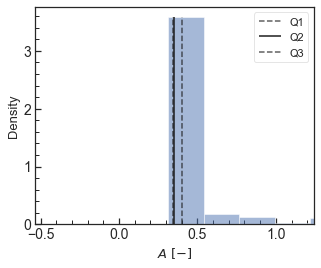

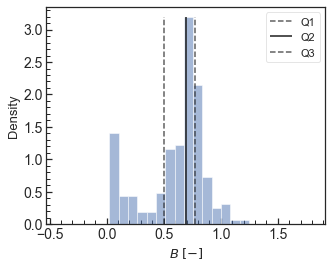

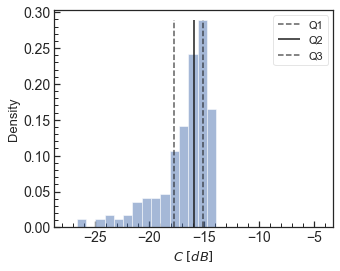

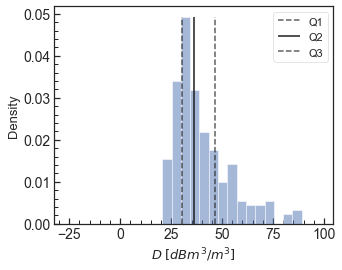

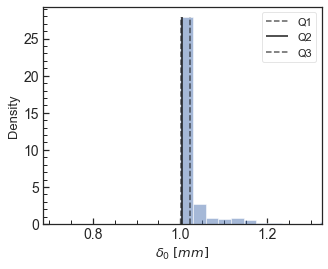

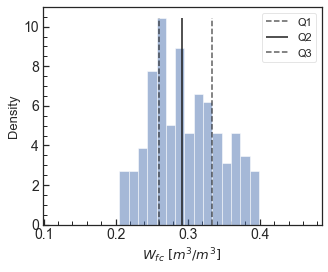

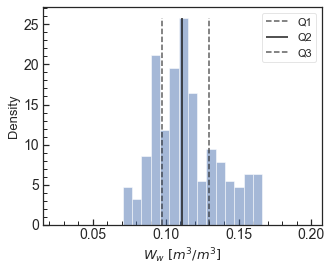

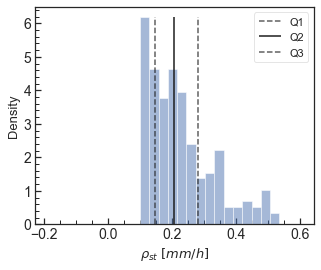

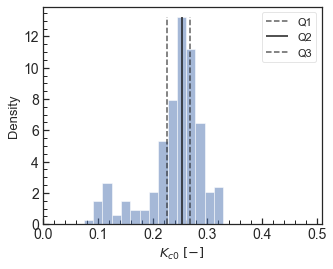

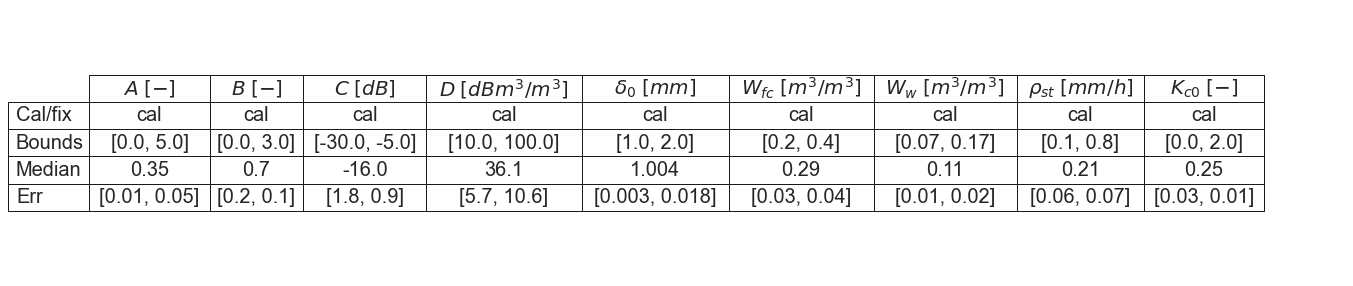

RMSE = 1.331117038905199
R= 0.7035427042015606
bias = -0.012655778621299716
KGE= 0.6971678026957879
RMSE = 0.050901869928277596
R (sim vs obs) = 0.7181788951719198
KGE= 0.6842633766728776


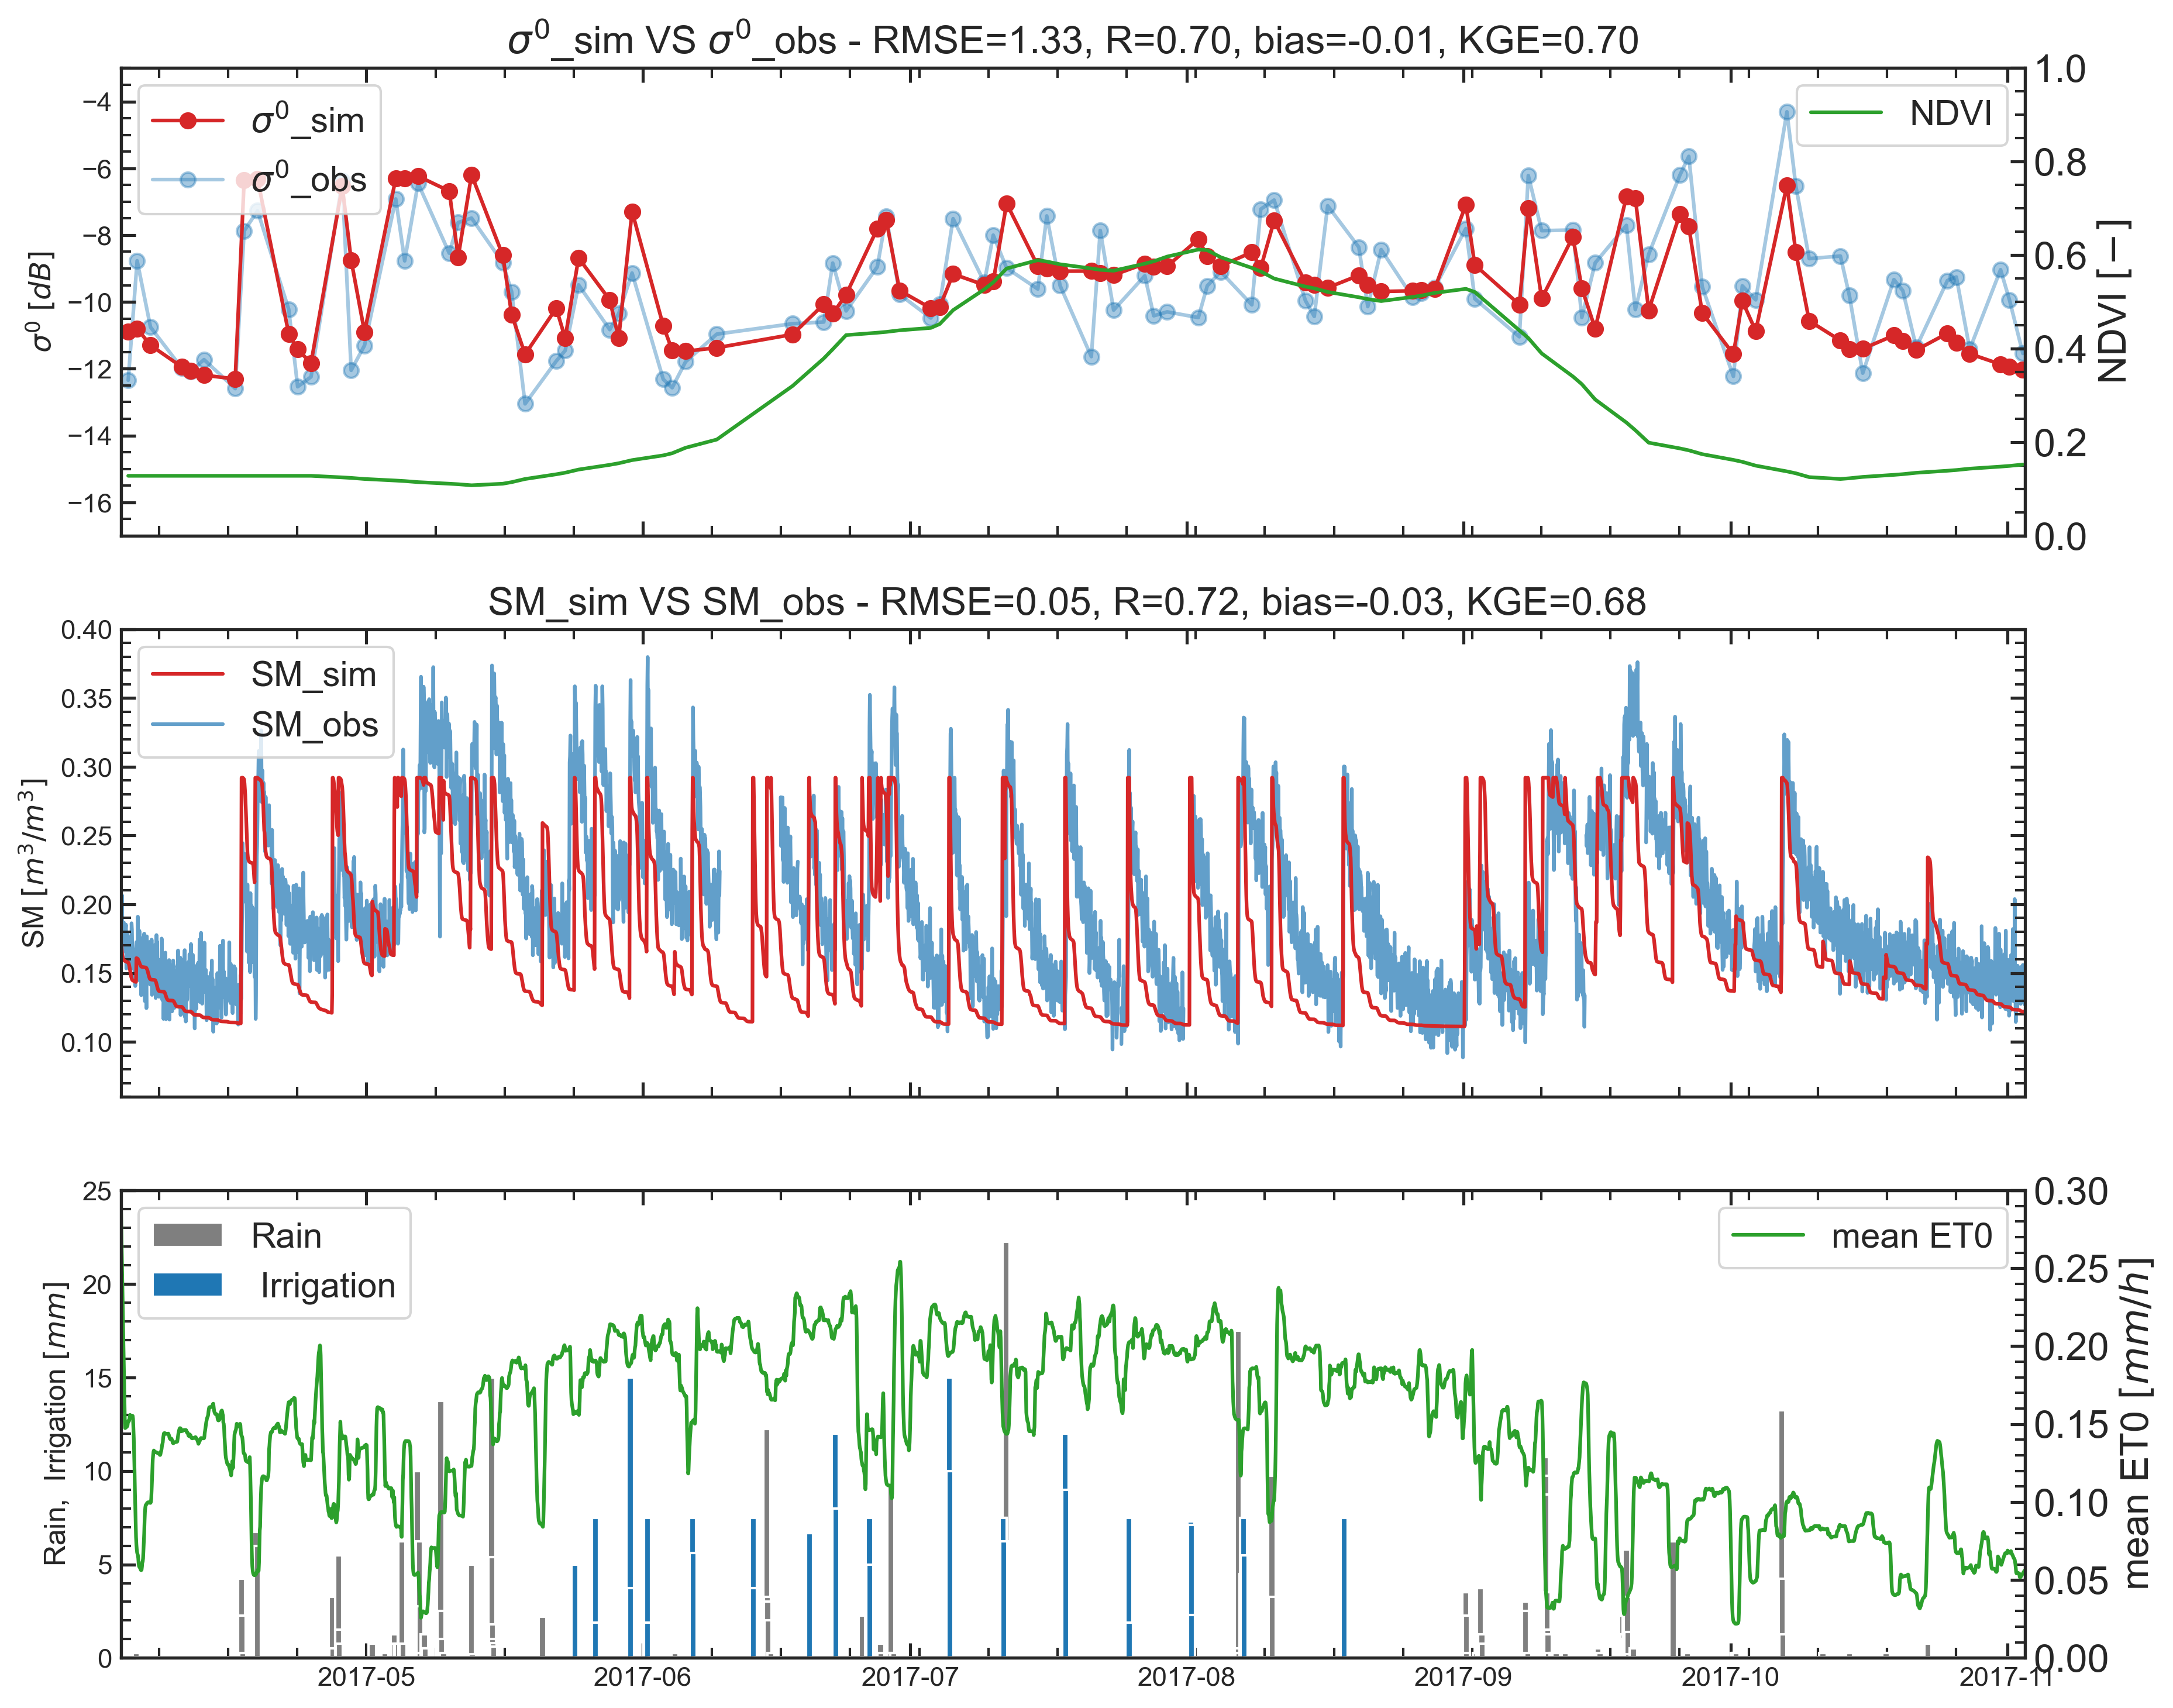

RMSE = 0.050901869928277596
R= 0.7181788951719199 R^2= 0.5157809254703595
bias= -0.028214591334847702


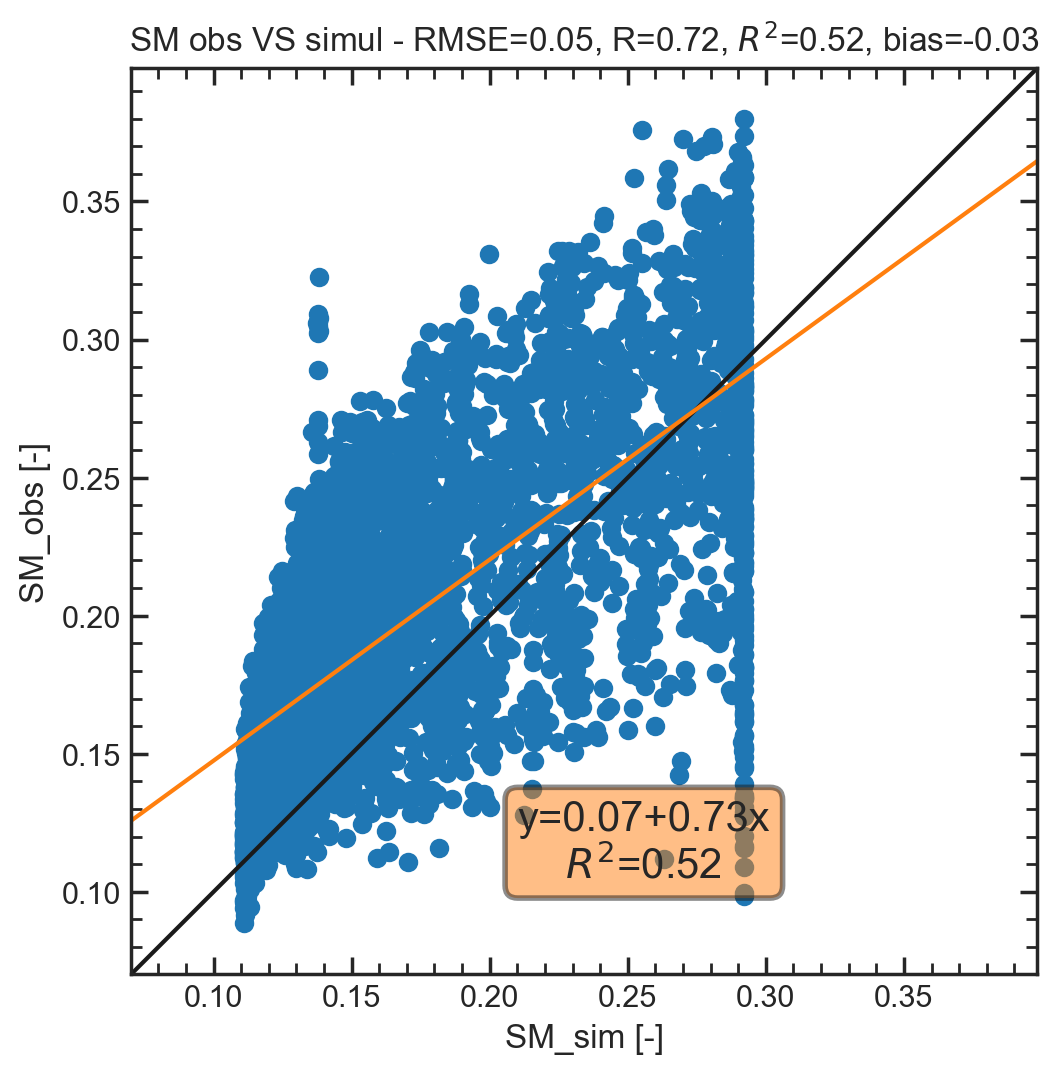

RMSE = 1.331117038905199
R= 0.7035427042015606 R^2= 0.49497233663524465
bias= -0.012655778621299716


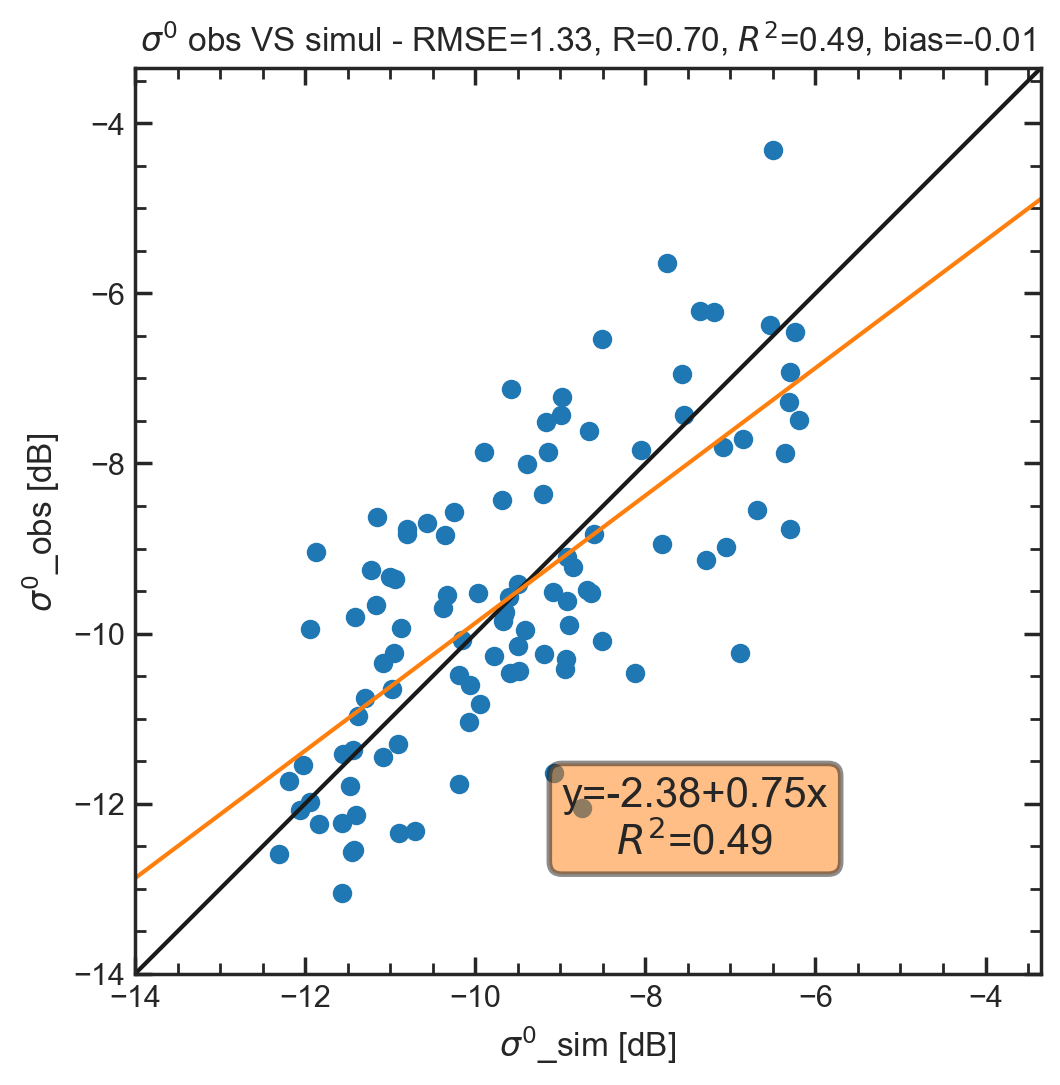

In [26]:
#############################################################################
# User choice
#############################################################################
opt_show = True if input('Show plots? [y/n]')=='y' else False
# automate = False

#############################################################################
# Analysis
#############################################################################

for y in [year]:
    for opt_fit_label in ['no-fit']:
        
        timestr=f'Simul_DEF\\{y}_FB\\{opt_fit_label}'
        PAR_dict = {label : PAR_DICTS[y][opt_fit_label][label] for label in PAR_DICTS[y][opt_fit_label]}
        
        opt_fit = True if opt_fit_label=='fit' else False
        _, rowLabels = parameters_analysis_fromfile(
            PAR_dict, PAR, PARn_str, bounds,
            timestr=timestr,
            automate=automate,
            opt_fit=opt_fit,
            nbins=15, opt_show=opt_show,)
        plt.close()
                
        if automate: opt_save=True
        else: opt_save = True if input('Save log with parameters\' values? [y/n]')=='y' else False
        
        if opt_save:
            for label in PAR_dict: PAR_dict[label].pop()
            try:
                with open('Plot\\'+timestr+'_params.txt', 'w') as f:
                    f.write(f'PAR_DICTS_{y}_{opt_fit_label}='+'{'+'\n')
                    for key, value in PAR_dict.items():
                        f.write("r'%s':%s,\n" % (key, value))
                    f.write('}')
            except ValueError: pass
            
        #####################################################################
        # Simulations
        #####################################################################
        PARn = [PAR_dict[label][3] for label in PAR_dict if label in PARn_str]
        WW,IRR,sigma0,KGE = IRR_WCM_allpar(PARn, inputs, user_in)

        
        #####################################################################
        # Table with param
        #####################################################################
        if automate: opt_save_table = True
        else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False
        
        fig, ax = plt.subplots(figsize=(24,5))
        row_height=0.1; col_width=0.1
        
        single_label = [label for label in PAR_dict][0]
        cellText = [
            [PAR_dict[label][1],
            PAR_dict[label][2],
            significant_figures_str(PAR_dict[label][4][0],
                                    PAR_dict[label][3])[1],
            [float(significant_figures_str(PAR_dict[label][4][0],
                                           PAR_dict[label][4][0])[1]),
             float(significant_figures_str(PAR_dict[label][4][0],
                                           PAR_dict[label][4][1])[1])]]
            for label in PAR_dict]
        cellText = [ [cellText[i][j] for i in range(len(cellText))]
                    for j in range(4)]
        
        colLabels = [ f'{label} {PAR_dict[label][0]}' for label in PAR_dict ]
        
        table = ax.table(cellText=cellText,
                          cellLoc='center', loc='center',
                          colLabels=colLabels,
                          rowLabels=rowLabels,
                        )
        
        for (row, col), cell in table.get_celld().items():
            if row == 0: # or col == 0:
                cell.set_text_props(weight='bold')
            cell.set_height(row_height)
            cell._loc = 'center'
        
        table.auto_set_font_size(False); table.set_fontsize(20)
        table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
        ax.axis('tight'); ax.axis('off')
        
        if opt_save_table: plt.savefig(f'Plot\\{timestr}_table.png')
        if opt_show: plt.show()
        plt.close()

        
        #####################################################################
        # Triple plot
        #####################################################################
        
        from scipy.signal import savgol_filter
                
        if automate: opt_save = True
        else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False
        
        fig, ax = plt.subplots(3, 1,constrained_layout=False,figsize=(14, 12), sharex=True,dpi=300,)
        filename = f'_triple_'+units+'_'+PAR_str_add
        from scipy.signal import savgol_filter
        
        plot_triple(fig, ax, times1=t_sat, data1=[VV, sigma0], data1_label=r'$\sigma^0$', 
                    input1=veg, input1_label=opt_veg,
                    times2=t, data2=[WW_obs, WW], data2_label=r'SM',
                    input2=[], input2_label='',
                    times3=t, data3=
                    [P,
                     IRR_obs,
                     savgol_filter(EPOT, window_length=24, polyorder=1, mode='interp')],
                    data3_label=['Rain', ' Irrigation', 'mean ET0'],
                    user_input=[irri],
                   )

        
        name=''
        if opt_save:
            optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
            name = timestr+filename # +f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
            plt.savefig('Plot\\'+name+'.png')
        
        if opt_show: plt.show()
        plt.close()
        
        
        #####################################################################
        # Scatterplot
        #####################################################################
        
        if automate: opt_save = True
        else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False
        
        filename = f'scatter_'+'sm_'+units+PAR_str_add # 'SM'
        
        plot_sim_vs_obs(sim=WW, obs=WW_obs, quantity='SM', um='[-]')
            
        if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')
        if opt_show: plt.show()
        plt.close()
        
        if automate: opt_save = True
        else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False
        
        filename = f'scatter_'+'sigma0_'+units+PAR_str_add # 'sigma0'
        
        plot_sim_vs_obs(sim=sigma0, obs=VV, quantity=r'$\sigma^0$', um='[dB]')
            
        if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')
        if opt_show: plt.show()
        plt.close()

# Components

In [ ]:
PAR_tot = [0.329, 0.56, -15, 30, 10, 0.32, 0.1, 0.4, 0.3]

A, B, C, D, W_max, WW_fc, WW_w, Kc0 = [PAR_dict[label][3] for label in PAR_dict]
t, t_sat, P, IRR_obs, EPOT, Kc, WW_obs, WW_sat, veg, angle, sig0_obs, freq, rho_st = inputs

angle_m = np.mean(angle)
Ks      = np.array([.0]*len(t)) # water stress coefficient
ET      = np.array([.0]*len(t)) # evapotranspiration
rho     = np.array([.0]*len(t)) # depletion fraction
PS      = np.array([.0]*len(t)) # deep percolation
W       = np.array([.0]*len(t)) # water content [mm]
WW      = np.array([.0]*len(t)) # water content [m3/m3]
WW[0]   = WW_obs[0] # initial value of sm [m3/m3]
depth   = np.array([.0]*len(t)) # dynamic depth [mm]
depth[0]= doi(freq=4, sand=45, clay=15, water=WW[0], angle=angle_m)*1000

W[0]    = WW_obs[0]*depth[0] # initial value of sm [mm]
sig0    = np.array([.0]*len(t_sat))

COST   = .0
LAMBDA = 1000
if irri==True: IRR = [0]*len(d) # daily, water content
else: IRR = IRR_obs


for i in [i+1 for i in range(len(t)-1)]:
    
    # Compute DoI of W[i-1]
    depth[i] = doi(freq=freq,
                sand=45, clay=15,
                water=WW[i-1],
                angle=angle_m)*1000
    
    # Build Ks curve    
    # Compute crop coeff and depletion fraction
    Kci = Kc[i]*Kc0
    rho[i]=rho_st+0.04*(5-Kci*EPOT[i]*24)
    if   rho[i]<0.1: COST += (rho[i]-0.1)**2 # regularization
    elif rho[i]>0.8: COST += (rho[i]-0.8)**2 # regularization
    
    if WW[i-1]>=(1-rho[i])*WW_fc:
        Ks[i]=1
    elif (WW[i-1]>WW_w)and(WW[i-1]<(1-rho[i])*WW_fc):
        Ks[i]=float(float(WW[i-1]-WW_w)/float((1-rho[i])*(WW_fc-WW_w)))
    else: Ks[i]=0
    
    # Water balance [mm]
    # W[i]=WW[i-1]*depth[i-1]+P[i]+IRR[i]-EPOT[i]*Kci*Ks[i]
    WW[i]=WW[i-1]+(P[i]+IRR[i]-EPOT[i]*Kci*Ks[i])/(depth[i])
    
    # Computation of deep percolation (water above field capacity)
    WW_s = 0.48
    if WW[i]>WW_s:
        WW[i]=WW_s
    elif WW[i]>WW_fc:
        WW[i]-=(WW[i]-WW_fc)*np.sqrt(60)

In [ ]:
theta  = angle*np.pi/180. # angle of incidence (rad)

sig0s_dB = C+D*WW_sat # sigma0_soil [dB]
T2 = np.exp((-2*B*veg)/np.cos(theta)) # attenuation
sig0v = A*veg*np.cos(theta)*(1-T2) # sigma0_veg [units]

if units=='lin':
    sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
    sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
    sig0=lin_db(sig0_lin) # sigma0_tot [dB]
elif units=='db':
    sig0 = T2*sig0s_dB+sig0v # sigma0_tot [db]
else: raise NameError('Please choose one of the options: lin/db')

In [ ]:
plt.plot(Kc*Kc0)
plt.plot(Ks)

In [ ]:
Ks

In [ ]:
plt.plot(EPOT*Kc*Kc0*Ks)

In [ ]:
plt.plot((1-0.01+0.04*(5-EPOT*Kc*24*Kc0))*WW_fc)
plt.plot(np.array([1]*len(t))*WW_w)
# plt.ylim(0,0.2)

In [ ]:
plt.plot(WW)
plt.plot(WW_obs)

In [ ]:
plt.scatter(WW,WW_obs)

In [ ]:
plt.plot(depth)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(doi(freq=6, sand=45, clay=15, water=WW_obs, angle=angle_m)*1000)
ax0 = ax.twinx()
ax0.plot(WW_obs, color='tab:orange')

# Extrapolate depth curves

In [ ]:
from scipy.optimize import curve_fit

def doi(freq:float, sand:float, clay:float, water:np.array, angle:float):
    """
    freq [GHz]
    angle [°]
    
    return depth [m]
    """
    c = 299792458 # m/s
    theta  = angle*np.pi/180. # angle [rad]
    
    coeff = {
        1.4:
        {
        'real' : [2.862, -0.012, 0.001, 3.803, 0.462,
                  -0.341, 119.006, -0.500, 0.633],
        'img' : [0.356, -0.003, -0.008, 5.507, 0.044,
                 -0.002, 17.753, -0.313, 0.206]
        },
        4:
        {
        'real':[ 2.927,-0.012,-0.001,5.505,0.371,
                0.062,114.826,-0.389,-0.547],
        'img':[0.004,0.001,0.002,0.951,0.005,
               -0.01,16.759,0.192,0.29]
        },
        6:
        {
        'real':[1.993,0.002,0.015,38.086,-0.176,
                -0.633,10.72,1.256,1.522],
        'img':[-0.123,0.002,0.003,7.502,-0.058,
               -0.116,2.942,0.452,0.543]
        }
    }
    
    coeff_r = np.array(coeff[freq]['real'])
    real = coeff_r[0]+coeff_r[1]*sand+coeff_r[2]*clay+\
    (coeff_r[3]+coeff_r[4]*sand+coeff_r[5]*clay)*water+\
    (coeff_r[6]+coeff_r[7]*sand+coeff_r[8]*clay)*(water**2)
        
    coeff_i = np.array(coeff[freq]['img'])
    img = coeff_i[0]+coeff_i[1]*sand+coeff_i[2]*clay+\
    (coeff_i[3]+coeff_i[4]*sand+coeff_i[5]*clay)*water+\
    (coeff_i[6]+coeff_i[7]*sand+coeff_i[8]*clay)*(water**2)
    
    depth =  c/(2*np.pi*freq*1e9)*(np.sqrt(real)/img)*np.cos(theta)
    
    return depth


# Define the function to fit to the data
def fit_func(freq, a, b, c):
    return a*freq**2 + b*freq + c

# Define the frequencies and depths for each set of data points
sand = 45
clay = 15
angle = 40
freqs = [1.4, 4, 6]
depths = []
for freq in freqs:
    depths.append([doi(freq, sand, clay, water, angle) for water in np.arange(0, 0.51, 0.01)])

# Fit a curve to each set of data points
fits = []
for i in range(len(freqs)):
    popt, _ = curve_fit(fit_func, freqs[i], depths[i])
    fits.append(popt)

# Define the frequencies at which to estimate the depth
new_freqs = np.arange(0.1, 10.1, 0.1)

# Estimate the depth at the new frequencies using the fitted curves
new_depths = []
for i in range(len(new_freqs)):
    depth = fit_func(new_freqs[i], *fits[0])
    if new_freqs[i] > freqs[0]:
        depth = fit_func(new_freqs[i], *fits[1])
    if new_freqs[i] > freqs[1]:
        depth = fit_func(new_freqs[i], *fits[2])
    new_depths.append(depth)

In [ ]:
plt.plot(new_depths)